# LSTM from Scratch for Vehicle Sensor Data

This notebook implements a Long Short-Term Memory (LSTM) network from scratch using only NumPy to process vehicle sensor data for predictive maintenance applications.

## About This Project

This LSTM implementation is part of a larger project focused on predictive maintenance for vehicles using OBD-II data. This work builds upon the Vanilla RNN implementation in this repository, which serves as the foundation for understanding recurrent neural networks.

## Research Background

This implementation is based on the methodology described in the research paper: [DeepAR + STAM + VAE for predictive maintenance](https://arxiv.org/abs/2407.17654). While the full system will eventually combine DeepAR, STAM, and VAE components, this LSTM implementation serves as a critical building block, as LSTM is the basis for both DeepAR and STAM architectures.


## Vanilla RNN vs LSTM: Key Differences

### The Problem with Vanilla RNN
- **Vanishing Gradient Problem**: When processing long sequences, the RNN has trouble remembering information from earlier timesteps. The gradients (used for learning) become very small and "vanish" as they propagate backward through time.
- **Short Memory**: Vanilla RNN can only remember information for a few timesteps back.

### Why LSTM is Better
- **Solves Vanishing Gradients**: LSTM uses a special architecture with **gates** that control information flow, allowing gradients to flow unchanged through long sequences.
- **Long-Term Memory**: LSTM can remember information for hundreds or thousands of timesteps.

### Key Architectural Differences

**Vanilla RNN:**
- Simple structure: Hidden state `h_t = tanh(W·h_{t-1} + U·x_t + b)`
- One memory component: Hidden state only
- Information flows directly through time

**LSTM:**
- Complex structure with **three gates**:
  - **Forget Gate**: Decides what to forget from previous memory
  - **Input Gate**: Decides what new information to store
  - **Output Gate**: Decides what to output based on current memory
- Two memory components:
  - **Cell State** (`C_t`): Long-term memory (flows unchanged)
  - **Hidden State** (`h_t`): Short-term memory (what to output)

**Simple Analogy:**
- Vanilla RNN = A person with short-term memory loss
- LSTM = A person with a notebook (cell state) and working memory (hidden state) who can selectively remember and forget

### When to Use What?
- **Vanilla RNN**: Short sequences, simple patterns, learning exercises
- **LSTM**: Long sequences, complex patterns, real-world applications (like our vehicle predictive maintenance)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Step 1: Load and Explore the Dataset

Let's start by loading the vehicle sensor dataset and understanding its structure. This is the same dataset we used for the Vanilla RNN, which contains 10 OBD-II sensor signals from a vehicle.


In [6]:
# Load vehicle sensor dataset
dataset_path = 'dataset/2017-07-31_Seat_Leon_RT_KA_Normal.csv'

# Load the dataset
df = pd.read_csv(dataset_path)

# Display basic information about the dataset
print(f"Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nFirst few rows:")
df.head()


Dataset loaded successfully!
Dataset shape: (57331, 11)

Column names:
['Time', 'Engine Coolant Temperature [Â°C]', 'Intake Manifold Absolute Pressure [kPa]', 'Engine RPM [RPM]', 'Vehicle Speed Sensor [km/h]', 'Intake Air Temperature [Â°C]', 'Air Flow Rate from Mass Flow Sensor [g/s]', 'Absolute Throttle Position [%]', 'Ambient Air Temperature [Â°C]', 'Accelerator Pedal Position D [%]', 'Accelerator Pedal Position E [%]']

First few rows:


,Time,Engine Coolant Temperature [Â°C],Intake Manifold Absolute Pressure [kPa],Engine RPM [RPM],Vehicle Speed Sensor [km/h],Intake Air Temperature [Â°C],Air Flow Rate from Mass Flow Sensor [g/s],Absolute Throttle Position [%],Ambient Air Temperature [Â°C],Accelerator Pedal Position D [%],Accelerator Pedal Position E [%]
0,07:28:41.017,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,07:28:41.107,25,98.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,07:28:41.168,25,98.0,869.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,07:28:41.258,25,98.0,869.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,07:28:41.348,25,98.0,869.0,0.0,22.0,NaN,NaN,NaN,NaN,NaN


### Explore Dataset Structure

Now let's examine the dataset more closely to understand:
- Missing values (NaN)
- Data types
- Basic statistics
- Memory usage

This helps us understand the data quality before we start preprocessing it for LSTM.


In [7]:
# Explore the dataset structure
print("Dataset Info:")
print(df.info())

print("\n" + "="*50)
print("Basic Statistics:")
print(df.describe())

print("\n" + "="*50)
print("Check for missing values:")
missing_values = df.isnull().sum()
print(missing_values)
print(f"\nTotal missing values: {missing_values.sum()}")
print(f"Percentage of missing values: {(missing_values.sum() / (df.shape[0] * df.shape[1])) * 100:.2f}%")

print("\n" + "="*50)
print("Data types:")
print(df.dtypes)

print("\n" + "="*50)
print("Dataset Memory Usage:")
print(f"Total memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57331 entries, 0 to 57330
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Time                                       57331 non-null  object 
 1   Engine Coolant Temperature [Â°C]           57331 non-null  int64  
 2   Intake Manifold Absolute Pressure [kPa]    57330 non-null  float64
 3   Engine RPM [RPM]                           57329 non-null  float64
 4   Vehicle Speed Sensor [km/h]                57328 non-null  float64
 5   Intake Air Temperature [Â°C]               57327 non-null  float64
 6   Air Flow Rate from Mass Flow Sensor [g/s]  57326 non-null  float64
 7   Absolute Throttle Position [%]             57325 non-null  float64
 8   Ambient Air Temperature [Â°C]              57324 non-null  float64
 9   Accelerator Pedal Position D [%]           57323 non-null  float64
 10  Accelera

## Step 2: Feature Selection and Data Preprocessing

For LSTM, we need to:
1. **Select features** (sensor signals) to use for prediction
2. **Handle missing values** (NaN)
3. **Prepare data** for time series prediction

### Feature Selection Strategy

For our LSTM implementation, we have selected **3 key features** in order to keep it simple to understand and that work together to provide a comprehensive view of vehicle state:

#### 1. Engine RPM [RPM] - Engine Revolutions Per Minute
**What it measures:** How fast the engine crankshaft is rotating  
**Why it's important:**
- **Core performance metric**: Directly indicates engine power output
- **Highly correlated with speed**: As RPM increases, vehicle speed typically increases
- **Predictive value**: RPM changes precede speed changes, helping LSTM predict future speed
- **Anomaly detection**: Abnormal RPM patterns can indicate engine problems (misfires, power loss, etc.)


#### 2. Vehicle Speed Sensor [km/h] - Vehicle Speed
**What it measures:** How fast the vehicle is moving  
**Why it's important:**
- **Primary output**: The main quantity we want to predict
- **Driver behavior indicator**: Speed patterns reflect driving style and road conditions
- **Temporal relationship**: Changes over time create patterns that LSTM can learn
- **Safety critical**: Abnormal speed patterns can indicate issues (braking problems, transmission issues)


#### 3. Intake Manifold Absolute Pressure [kPa] - Engine Load Indicator
**What it measures:** Air pressure inside the intake manifold (how hard the engine is working)  
**Why it's important:**
- **Engine load indicator**: Directly measures how much work the engine is doing
- **Mechanical insight**: Reflects engine health and efficiency
- **Predictive value**: High MAP → more air → higher RPM → higher speed (causal relationship)
- **Anomaly detection**: Abnormal MAP values can indicate mechanical issues:
  - High MAP but low RPM = potential engine problem (clogged filter, vacuum leak)
  - Low MAP but high RPM = potential air intake issue

### Why These Three Features Together?

**1. Complementary Information:**
- **RPM** = engine rotational speed
- **Speed** = vehicle movement
- **MAP** = engine load/air intake
- Together, they provide a complete picture: engine state → power output → vehicle movement

**2. Causal Relationship:**
```
MAP (engine load) → RPM (engine speed) → Speed (vehicle movement)
```
The LSTM can learn this causal chain and predict future values based on current MAP and RPM.

**4. Predictive Maintenance Benefits:**
- **RPM anomalies**: Engine misfires, power loss
- **Speed anomalies**: Braking issues, transmission problems
- **MAP anomalies**: Air intake problems, vacuum leaks, engine efficiency issues
- **Combined patterns**: Can detect complex issues that individual sensors might miss

**5. Starting Simple but Effective:**
- 3 features provide enough complexity for meaningful predictions
- LSTM can handle more features, but starting with 3 helps us understand the architecture
- Easy to extend later to include all 10 sensor signals if needed



In [8]:
# Select the 3 features: RPM, Vehicle Speed, and Intake Manifold Pressure
# Also keep Time for reference
selected_features = [
    'Time',
    'Engine RPM [RPM]',
    'Vehicle Speed Sensor [km/h]',
    'Intake Manifold Absolute Pressure [kPa]'
]

# Create a new dataframe with only our selected features
sensor_df = df[selected_features].copy()

# Rename columns for easier working
sensor_df.columns = ['Time', 'RPM', 'Vehicle_Speed_kmh', 'MAP_kPa']

# Display information about the selected data
print("="*60)
print("Selected Features for LSTM")
print("="*60)
print(f"Original dataset shape: {df.shape}")
print(f"Selected features shape: {sensor_df.shape}")
print(f"\nSelected columns: {sensor_df.columns.tolist()}")
print(f"\nFirst 10 rows:")
print(sensor_df.head(10))

print("\n" + "="*60)
print("Missing Values Check (Before Cleaning)")
print("="*60)
missing_before = sensor_df.isnull().sum()
print(missing_before)
print(f"\nTotal missing values: {missing_before.sum()}")
print(f"Rows with at least one missing value: {sensor_df.isnull().any(axis=1).sum()}")

# Remove rows with NaN values - keep only rows where all 3 features have values
print("\n" + "="*60)
print("Cleaning Data: Removing Rows with Missing Values")
print("="*60)
original_rows = len(sensor_df)
sensor_df = sensor_df.dropna()
rows_after = len(sensor_df)
rows_removed = original_rows - rows_after

print(f"Original number of rows: {original_rows}")
print(f"Rows after removing NaN: {rows_after}")
print(f"Rows removed: {rows_removed}")
print(f"Percentage of data retained: {(rows_after/original_rows)*100:.2f}%")

print("\n" + "="*60)
print("Data After Cleaning")
print("="*60)
print(f"Shape: {sensor_df.shape}")
print(f"\nMissing values check (should all be 0):")
print(sensor_df.isnull().sum())

print("\n" + "="*60)
print("Basic Statistics of Selected Features")
print("="*60)
print(sensor_df.describe())


Selected Features for LSTM
Original dataset shape: (57331, 11)
Selected features shape: (57331, 4)

Selected columns: ['Time', 'RPM', 'Vehicle_Speed_kmh', 'MAP_kPa']

First 10 rows:
           Time    RPM  Vehicle_Speed_kmh  MAP_kPa
0  07:28:41.017    NaN                NaN      NaN
1  07:28:41.107    NaN                NaN     98.0
2  07:28:41.168  869.0                NaN     98.0
3  07:28:41.258  869.0                0.0     98.0
4  07:28:41.348  869.0                0.0     98.0
5  07:28:41.439  869.0                0.0     98.0
6  07:28:41.528  869.0                0.0     98.0
7  07:28:41.618  869.0                0.0     98.0
8  07:28:41.708  869.0                0.0     98.0
9  07:28:41.769  869.0                0.0     98.0

Missing Values Check (Before Cleaning)
Time                 0
RPM                  2
Vehicle_Speed_kmh    3
MAP_kPa              1
dtype: int64

Total missing values: 6
Rows with at least one missing value: 3

Cleaning Data: Removing Rows with Missing Valu

In [9]:
# ============================================================================
# WHY NORMALIZATION?
# ============================================================================
# Normalization is essential for neural networks including LSTM because:
#
# 1. DIFFERENT SCALES: Our features have very different ranges:
#    - RPM: ranges from 0 to ~3333 (thousands)
#    - Vehicle Speed: ranges from 0 to ~198 (hundreds)
#    - MAP: ranges from ~36 to ~200 (hundreds)
#    Without normalization, features with larger values (like RPM) would
#    dominate the learning process, and the LSTM would pay more attention
#    to RPM than to Speed or MAP, even if Speed or MAP are equally important.
#
# 2. GRADIENT STABILITY: LSTM uses gradients (derivatives) to learn. When
#    features have different scales, gradients can become very large for
#    some features and very small for others. This makes training unstable
#    and slow. Normalized data ensures all features contribute equally to
#    the gradient calculations.
#
# 3. FASTER CONVERGENCE: Normalized data helps the optimization algorithm
#    (gradient descent) converge faster. The LSTM can learn the patterns
#    more efficiently when all features are on a similar scale.
#
# 4. NUMERICAL STABILITY: Prevents numerical overflow/underflow during
#    matrix multiplications and activation functions (like tanh, sigmoid)
#    in the LSTM gates.
#
# 5. BETTER GATE OPERATIONS: LSTM gates (forget, input, output) use
#    sigmoid and tanh functions that work best with inputs in the range
#    [-1, 1] or [0, 1]. Normalized data ensures gate operations work
#    correctly and efficiently.
#
# We'll use Min-Max normalization to scale all features to [0, 1]:
#   normalized_value = (value - min) / (max - min)
#
# This preserves the relative relationships between values while putting
# everything on the same scale.
# ============================================================================

# Extract the sensor columns (excluding Time)
# We'll normalize RPM, Vehicle_Speed_kmh, and MAP_kPa
features = sensor_df[['RPM', 'Vehicle_Speed_kmh', 'MAP_kPa']].values

# Calculate min and max for each feature (column-wise)
# We'll store these so we can denormalize later if needed for predictions
feature_min = features.min(axis=0)  # Min for each feature: [RPM_min, Speed_min, MAP_min]
feature_max = features.max(axis=0)  # Max for each feature: [RPM_max, Speed_max, MAP_max]

print("="*60)
print("Original Feature Ranges (Before Normalization)")
print("="*60)
print(f"RPM:              [{feature_min[0]:.2f}, {feature_max[0]:.2f}]")
print(f"Vehicle Speed:    [{feature_min[1]:.2f}, {feature_max[1]:.2f}]")
print(f"MAP (kPa):        [{feature_min[2]:.2f}, {feature_max[2]:.2f}]")

# Apply Min-Max normalization: (x - min) / (max - min)
# This scales each feature to [0, 1]
normalized_features = (features - feature_min) / (feature_max - feature_min)

print("\n" + "="*60)
print("After Normalization (All features scaled to [0, 1])")
print("="*60)
print(f"Normalized RPM range:        [{normalized_features[:, 0].min():.4f}, {normalized_features[:, 0].max():.4f}]")
print(f"Normalized Speed range:      [{normalized_features[:, 1].min():.4f}, {normalized_features[:, 1].max():.4f}]")
print(f"Normalized MAP range:        [{normalized_features[:, 2].min():.4f}, {normalized_features[:, 2].max():.4f}]")

# Verify normalization worked correctly
print("\n" + "="*60)
print("Verification: All features should be in [0, 1] range")
print("="*60)
print(f"All values >= 0: {np.all(normalized_features >= 0)}")
print(f"All values <= 1: {np.all(normalized_features <= 1)}")
print(f"Feature means (should be between 0 and 1):")
print(f"  RPM mean: {normalized_features[:, 0].mean():.4f}")
print(f"  Speed mean: {normalized_features[:, 1].mean():.4f}")
print(f"  MAP mean: {normalized_features[:, 2].mean():.4f}")

# Store normalized features for later use
# We'll use this for LSTM training
normalized_data = normalized_features.copy()

print("\n" + "="*60)
print("Normalization Complete!")
print("="*60)
print(f"Normalized data shape: {normalized_data.shape}")
print(f"  - {normalized_data.shape[0]} timesteps")
print(f"  - {normalized_data.shape[1]} features (RPM, Speed, MAP)")
print("\nNote: We've stored min and max values so we can denormalize")
print("predictions later if needed.")


Original Feature Ranges (Before Normalization)
RPM:              [0.00, 3333.00]
Vehicle Speed:    [0.00, 198.00]
MAP (kPa):        [36.00, 232.00]

After Normalization (All features scaled to [0, 1])
Normalized RPM range:        [0.0000, 1.0000]
Normalized Speed range:      [0.0000, 1.0000]
Normalized MAP range:        [0.0000, 1.0000]

Verification: All features should be in [0, 1] range
All values >= 0: True
All values <= 1: True
Feature means (should be between 0 and 1):
  RPM mean: 0.4852
  Speed mean: 0.3812
  MAP mean: 0.4910

Normalization Complete!
Normalized data shape: (57328, 3)
  - 57328 timesteps
  - 3 features (RPM, Speed, MAP)

Note: We've stored min and max values so we can denormalize
predictions later if needed.


## Step 3: Train/Validation/Test Split (Temporal Split)

### Split Strategy
- **Training**: First 70% of timesteps (earlier data)
- **Validation**: Next 15% of timesteps (middle data)
- **Test**: Last 15% of timesteps (later data)

This ensures:
- Model learns from past data
- Validates on unseen future data
- Tests on most recent future data
- No temporal leakage between splits


In [10]:
# ============================================================================
# TRAIN/VALIDATION/TEST SPLIT (TEMPORAL SPLIT)
# ============================================================================
# Split the normalized data BEFORE creating sequences to prevent data leakage
# ============================================================================

# Get total number of timesteps
total_samples = len(normalized_data)
print("="*60)
print("Train/Validation/Test Split (Temporal Split)")
print("="*60)
print(f"Total timesteps: {total_samples:,}")

# Define split ratios: 70% train, 15% validation, 15% test
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

# Calculate split indices
train_end = int(total_samples * train_ratio)
val_end = int(total_samples * (train_ratio + val_ratio))

# Split the data (maintaining temporal order - no shuffling!)
train_data = normalized_data[:train_end]
val_data = normalized_data[train_end:val_end]
test_data = normalized_data[val_end:]

print("\n" + "="*60)
print("Split Summary")
print("="*60)
print(f"Training set:   {len(train_data):,} samples ({len(train_data)/total_samples*100:.1f}%)")
print(f"Validation set: {len(val_data):,} samples ({len(val_data)/total_samples*100:.1f}%)")
print(f"Test set:       {len(test_data):,} samples ({len(test_data)/total_samples*100:.1f}%)")

print("\n" + "="*60)
print("Split Indices (Boundary Check)")
print("="*60)
print(f"Training:   indices 0 to {train_end-1} (exclusive)")
print(f"Validation: indices {train_end} to {val_end-1} (exclusive)")
print(f"Test:       indices {val_end} to {total_samples-1}")

print("\n" + "="*60)
print("Data Shapes After Split")
print("="*60)
print(f"Train data shape:   {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape:     {test_data.shape}")

# Verify no overlap between splits
print("\n" + "="*60)
print("Verification: No Overlap Between Splits")
print("="*60)
print(f"Train end index: {train_end}")
print(f"Val start index: {train_end} ✓")
print(f"Val end index: {val_end}")
print(f"Test start index: {val_end} ✓")
print(f"Total samples: {len(train_data) + len(val_data) + len(test_data)}")
print(f"Matches original: {len(train_data) + len(val_data) + len(test_data) == total_samples}")

print("\n" + "="*60)
print("First Few Samples from Each Split")
print("="*60)
print("Training set (first 3):")
print(train_data[:3])
print("\nValidation set (first 3):")
print(val_data[:3])
print("\nTest set (first 3):")
print(test_data[:3])

print("\n" + "="*60)
print("✓ Split Complete - No Data Leakage!")
print("="*60)


Train/Validation/Test Split (Temporal Split)
Total timesteps: 57,328

Split Summary
Training set:   40,129 samples (70.0%)
Validation set: 8,599 samples (15.0%)
Test set:       8,600 samples (15.0%)

Split Indices (Boundary Check)
Training:   indices 0 to 40128 (exclusive)
Validation: indices 40129 to 48727 (exclusive)
Test:       indices 48728 to 57327

Data Shapes After Split
Train data shape:   (40129, 3)
Validation data shape: (8599, 3)
Test data shape:     (8600, 3)

Verification: No Overlap Between Splits
Train end index: 40129
Val start index: 40129 ✓
Val end index: 48728
Test start index: 48728 ✓
Total samples: 57328
Matches original: True

First Few Samples from Each Split
Training set (first 3):
[[0.26072607 0.         0.31632653]
 [0.26072607 0.         0.31632653]
 [0.26072607 0.         0.31632653]]

Validation set (first 3):
[[0.74377438 0.73737374 0.85714286]
 [0.74377438 0.74242424 0.85714286]
 [0.74377438 0.74242424 0.85714286]]

Test set (first 3):
[[0.41584158 0.2727

## Step 4: Create Sequences for LSTM Training

Now that we've split the data, we'll create sequences **within each split separately** to ensure no data leakage.

### Sequence Parameters
- **Sequence Length**: 50 timesteps (LSTM can handle longer sequences than vanilla RNN)
- **Prediction**: Next 1 timestep (t+1) for all 3 features
- **Features**: RPM, Speed, MAP (all 3 features)

### How Sequences Work
For each split, we create sliding windows:
- **Input (X)**: 50 consecutive timesteps → shape (50, 3)
- **Target (y)**: Next timestep (t+1) → shape (3,)

Example:
```
Window 1: [t0, t1, ..., t49] → predict t50
Window 2: [t1, t2, ..., t50] → predict t51
Window 3: [t2, t3, ..., t51] → predict t52
...
```

### Why Sequence Length = 50?
- **More Context**: Longer sequences give LSTM more historical information
- **LSTM Advantage**: LSTM handles long sequences better than vanilla RNN (solves vanishing gradients)
- **Better Patterns**: Can capture longer-term dependencies in vehicle behavior
- **Production Ready**: More realistic for actual predictive maintenance applications


In [12]:
# ============================================================================
# CREATE SEQUENCES FOR LSTM TRAINING
# ============================================================================
# Create sequences within each split separately to prevent data leakage
# ============================================================================

def create_sequences(data, sequence_length=50):
    """
    Create sliding window sequences from time series data.
    
    Args:
        data: numpy array of shape (num_timesteps, num_features)
        sequence_length: number of timesteps to use as input (window size)
    
    Returns:
        X: input sequences of shape (num_sequences, sequence_length, num_features)
        y: target sequences of shape (num_sequences, num_features)
    
    Formula for number of sequences:
        num_sequences = num_timesteps - sequence_length
    
    Explanation:
        - If we have N timesteps and sequence_length = L
        - We can create sequences starting from index 0 to index (N-L-1)
        - Last valid sequence: indices [N-L, N-L+1, ..., N-1] → predicts N
        - So we can create (N-L) sequences total
        
    Example:
        - num_timesteps = 100, sequence_length = 50
        - num_sequences = 100 - 50 = 50 sequences
        - Sequence 0: indices [0, 1, ..., 49] → predict 50
        - Sequence 1: indices [1, 2, ..., 50] → predict 51
        - ...
        - Sequence 49: indices [49, 50, ..., 98] → predict 99
    """
    X = []
    y = []
    
    # ============================================================================
    # FORMULA FOR NUMBER OF SEQUENCES:
    # ============================================================================
    # num_sequences = len(data) - sequence_length
    # 
    # Why? Because we need at least 'sequence_length' timesteps to create one sequence,
    # and we need one more timestep to predict (the target). So:
    # - Last valid starting index = len(data) - sequence_length - 1
    # - But we range from 0 to (len(data) - sequence_length - 1), inclusive
    # - Total sequences = (len(data) - sequence_length - 1) - 0 + 1
    #                     = len(data) - sequence_length
    # 
    # Example with 100 timesteps and sequence_length = 50:
    #   - We can start sequences at indices 0, 1, 2, ..., 49
    #   - That's 50 sequences total (indices 0 to 49 inclusive)
    #   - Formula: 100 - 50 = 50 ✓
    # ============================================================================
    
    # Create sliding windows
    # For each position i, we use [i, i+1, ..., i+sequence_length-1] as input
    # and predict [i+sequence_length] as target
    # Range: i goes from 0 to (len(data) - sequence_length - 1)
    # This creates exactly (len(data) - sequence_length) sequences
    for i in range(len(data) - sequence_length):
        # Input: sequence_length consecutive timesteps
        X.append(data[i:i + sequence_length])
        # Target: next timestep (t+1)
        y.append(data[i + sequence_length])
    
    return np.array(X), np.array(y)

# Set sequence parameters (matching vanilla RNN approach but with longer sequences)
sequence_length = 50  # Longer sequences for LSTM (vanilla RNN used 10)
prediction_length = 1  # Predict next 1 timestep

print("="*60)
print("Creating Sequences for LSTM")
print("="*60)
print(f"Sequence length (window size): {sequence_length}")
print(f"Prediction length: {prediction_length} timestep(s)")
print(f"Features: 3 (RPM, Speed, MAP)")
print("\n" + "="*60)

# Create sequences for each split separately
print("Creating sequences for Training set...")
X_train, y_train = create_sequences(train_data, sequence_length)
print(f"✓ Training sequences created: {X_train.shape[0]:,} sequences")

print("\nCreating sequences for Validation set...")
X_val, y_val = create_sequences(val_data, sequence_length)
print(f"✓ Validation sequences created: {X_val.shape[0]:,} sequences")

print("\nCreating sequences for Test set...")
X_test, y_test = create_sequences(test_data, sequence_length)
print(f"✓ Test sequences created: {X_test.shape[0]:,} sequences")

print("\n" + "="*60)
print("Sequence Shapes")
print("="*60)
print(f"X_train shape: {X_train.shape}  → (num_sequences, sequence_length, num_features)")
print(f"y_train shape: {y_train.shape}  → (num_sequences, num_features)")
print(f"\nX_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"\nX_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

print("\n" + "="*60)
print("Sequence Details")
print("="*60)
print(f"- Each input sequence has {sequence_length} timesteps")
print(f"- Each timestep has {X_train.shape[2]} features (RPM, Speed, MAP)")
print(f"- Each target has {y_train.shape[1]} values (next RPM, Speed, MAP)")
print(f"\nInterpretation: Given {sequence_length} timesteps of data, predict timestep {sequence_length+1}")

print("\n" + "="*60)
print("Example: First Training Sequence")
print("="*60)
print(f"Input (X_train[0]) - shape {X_train[0].shape}:")
print(f"First 3 timesteps of first sequence:")
print(X_train[0][:3])
print(f"\nTarget (y_train[0]) - shape {y_train[0].shape}:")
print(y_train[0])
print(f"\nThis means:")
print(f"  Given timesteps 0-49, predict timestep 50")
print(f"  Input features: {X_train[0][0]} (first timestep)")
print(f"  Target features: {y_train[0]} (next timestep)")

# Verify no data leakage: Check that sequences don't cross split boundaries
print("\n" + "="*60)
print("Verification: No Data Leakage")
print("="*60)
print(f"Training sequences use indices: 0 to {len(train_data)-1}")
print(f"  Last training sequence uses indices: {len(train_data)-sequence_length-1} to {len(train_data)-1}")
print(f"  Predicts index: {len(train_data)}")
print(f"\nValidation sequences use indices: {train_end} to {val_end-1}")
print(f"  First validation sequence uses indices: {train_end} to {train_end+sequence_length-1}")
print(f"  Gap between train and val: {train_end - len(train_data)} timesteps ✓")
print(f"\nTest sequences use indices: {val_end} to {total_samples-1}")
print(f"  First test sequence uses indices: {val_end} to {val_end+sequence_length-1}")
print(f"  Gap between val and test: {val_end - (train_end + len(val_data))} timesteps ✓")

print("\n" + "="*60)
print("✓ Sequences Created - Ready for LSTM Training!")
print("="*60)


Creating Sequences for LSTM
Sequence length (window size): 50
Prediction length: 1 timestep(s)
Features: 3 (RPM, Speed, MAP)

Creating sequences for Training set...
✓ Training sequences created: 40,079 sequences

Creating sequences for Validation set...
✓ Validation sequences created: 8,549 sequences

Creating sequences for Test set...
✓ Test sequences created: 8,550 sequences

Sequence Shapes
X_train shape: (40079, 50, 3)  → (num_sequences, sequence_length, num_features)
y_train shape: (40079, 3)  → (num_sequences, num_features)

X_val shape: (8549, 50, 3)
y_val shape: (8549, 3)

X_test shape: (8550, 50, 3)
y_test shape: (8550, 3)

Sequence Details
- Each input sequence has 50 timesteps
- Each timestep has 3 features (RPM, Speed, MAP)
- Each target has 3 values (next RPM, Speed, MAP)

Interpretation: Given 50 timesteps of data, predict timestep 51

Example: First Training Sequence
Input (X_train[0]) - shape (50, 3):
First 3 timesteps of first sequence:
[[0.26072607 0.         0.316326

## Step 5: Understanding LSTM Architecture

### What is LSTM?

**Long Short-Term Memory (LSTM)** is a type of recurrent neural network that solves the vanishing gradient problem of vanilla RNNs by using **gates** to control information flow.

### Key Components

**1. Two Memory States:**
- **Cell State (C_t)**: Long-term memory that flows through time mostly unchanged
- **Hidden State (h_t)**: Short-term memory that is output at each timestep

**2. Three Gates (Control Information Flow):**
- **Forget Gate (f_t)**: Decides what to forget from cell state
- **Input Gate (i_t)**: Decides what new information to store in cell state
- **Output Gate (o_t)**: Decides what to output based on cell state

### LSTM Equations

At each timestep `t`, given input `x_t`, previous hidden state `h_{t-1}`, and previous cell state `C_{t-1}`:

**Forget Gate:**
```
f_t = σ(W_f · [h_{t-1}, x_t] + b_f)
```
Decides what to forget (0 = forget, 1 = keep)

**Input Gate:**
```
i_t = σ(W_i · [h_{t-1}, x_t] + b_i)
C̃_t = tanh(W_C · [h_{t-1}, x_t] + b_C)
```
Decides what new information to store and what the new candidate values are

**Cell State Update:**
```
C_t = f_t ⊙ C_{t-1} + i_t ⊙ C̃_t
```
Forget old information + Add new information

**Output Gate:**
```
o_t = σ(W_o · [h_{t-1}, x_t] + b_o)
h_t = o_t ⊙ tanh(C_t)
```
Decides what to output and computes new hidden state

**Where:**
- `σ` = sigmoid function (outputs 0-1)
- `tanh` = hyperbolic tangent (outputs -1 to 1)
- `⊙` = element-wise multiplication (Hadamard product)
- `[h_{t-1}, x_t]` = concatenation of hidden state and input

### Key Insight

The **cell state (C_t)** acts like a "conveyor belt" - it flows through time mostly unchanged, allowing information to persist for long sequences. The gates control what information flows in and out of this cell state, solving the vanishing gradient problem.


## Step 6: LSTM Implementation - Parameter Initialization

We'll implement LSTM from scratch using NumPy. First, we need to initialize all the weight matrices and bias vectors for the three gates (forget, input, output) and the cell state candidate.

### Parameters Needed

For each gate, we need:
- **Weight matrices**: Connect input and hidden state to gate outputs
- **Bias vectors**: Add bias terms

**Total parameters:**
- Forget gate: W_f, b_f
- Input gate: W_i, b_i  
- Cell candidate: W_C, b_C
- Output gate: W_o, b_o

**Weight matrix shapes:**
- Input size: 3 (RPM, Speed, MAP)
- Hidden size: We'll choose (e.g., 32, 64, 128)
- Weight shape: (input_size + hidden_size, hidden_size)
- Bias shape: (hidden_size,)

**Why concatenation?**
- We concatenate [h_{t-1}, x_t] to form a single vector
- This makes weight matrices simpler: W · [h, x] instead of separate W_hh and W_xh


In [15]:
# ============================================================================
# LSTM PARAMETER INITIALIZATION
# ============================================================================
# Initialize all weight matrices and bias vectors for LSTM gates
# ============================================================================

class LSTM:
    """
    LSTM (Long Short-Term Memory) implementation from scratch using NumPy.
    
    This class implements a complete LSTM with:
    - Forward pass (processes sequences through LSTM)
    - Parameter initialization with proper weight initialization
    - Support for batching (process multiple sequences together)
    """
    
    def __init__(self, input_size, hidden_size, output_size, seed=42):
        """
        Initialize LSTM parameters.
        
        Args:
            input_size: Dimension of input features (e.g., 3 for RPM, Speed, MAP)
            hidden_size: Dimension of hidden state and cell state (e.g., 32, 64)
            output_size: Dimension of output/prediction (e.g., 3 for RPM, Speed, MAP)
            seed: Random seed for reproducibility
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Set random seed for reproducibility
        np.random.seed(seed)
        
        # ====================================================================
        # WEIGHT INITIALIZATION
        # ====================================================================
        # We use Xavier/Glorot initialization for better gradient flow
        # Xavier: std = sqrt(2 / (fan_in + fan_out))
        #
        # For LSTM gates, we concatenate [h_{t-1}, x_t], so:
        # fan_in = input_size + hidden_size
        # fan_out = hidden_size
        # ====================================================================
        
        fan_in = input_size + hidden_size
        fan_out = hidden_size
        xavier_std = np.sqrt(2.0 / (fan_in + fan_out))
        
        # Forget Gate: f_t = σ(W_f · [h_{t-1}, x_t] + b_f)
        self.W_f = np.random.normal(0, xavier_std, (fan_in, hidden_size))
        self.b_f = np.zeros((hidden_size,))
        
        # Input Gate: i_t = σ(W_i · [h_{t-1}, x_t] + b_i)
        self.W_i = np.random.normal(0, xavier_std, (fan_in, hidden_size))
        self.b_i = np.zeros((hidden_size,))
        
        # Cell Candidate: C̃_t = tanh(W_C · [h_{t-1}, x_t] + b_C)
        self.W_C = np.random.normal(0, xavier_std, (fan_in, hidden_size))
        self.b_C = np.zeros((hidden_size,))
        
        # Output Gate: o_t = σ(W_o · [h_{t-1}, x_t] + b_o)
        self.W_o = np.random.normal(0, xavier_std, (fan_in, hidden_size))
        self.b_o = np.zeros((hidden_size,))
        
        # Output Layer: y_t = W_hy · h_t + b_y
        # Maps hidden state to output predictions
        xavier_std_output = np.sqrt(2.0 / (hidden_size + output_size))
        self.W_hy = np.random.normal(0, xavier_std_output, (hidden_size, output_size))
        self.b_y = np.zeros((output_size,))
        
        # Store parameters in a list for easy access
        self.parameters = {
            'W_f': self.W_f, 'b_f': self.b_f,
            'W_i': self.W_i, 'b_i': self.b_i,
            'W_C': self.W_C, 'b_C': self.b_C,
            'W_o': self.W_o, 'b_o': self.b_o,
            'W_hy': self.W_hy, 'b_y': self.b_y
        }
        
        print("="*60)
        print("LSTM Initialization Complete")
        print("="*60)
        print(f"Input size: {input_size}")
        print(f"Hidden size: {hidden_size}")
        print(f"Output size: {output_size}")
        print(f"\nTotal parameters:")
        total_params = sum(p.size for p in self.parameters.values())
        print(f"  Total: {total_params:,}")
        print(f"\nParameter shapes:")
        print(f"  Forget gate W_f: {self.W_f.shape}, b_f: {self.b_f.shape}")
        print(f"  Input gate W_i: {self.W_i.shape}, b_i: {self.b_i.shape}")
        print(f"  Cell candidate W_C: {self.W_C.shape}, b_C: {self.b_C.shape}")
        print(f"  Output gate W_o: {self.W_o.shape}, b_o: {self.b_o.shape}")
        print(f"  Output layer W_hy: {self.W_hy.shape}, b_y: {self.b_y.shape}")

# Initialize LSTM
# Choose hidden_size - larger = more capacity but slower training
# 
# Considerations:
# - Vanilla RNN started with 32, but increased to 128 for better performance
# - LSTM has 4 gates (forget, input, output, cell) vs 1 in vanilla RNN
# - We have 3 features (vs 2 in vanilla RNN) and longer sequences (50 vs 10)
# - For learning long-term patterns with 3 features, we need more capacity
#
# Recommendation:
# - hidden_size = 64: Good balance for learning patterns (start here)
# - hidden_size = 128: More capacity, better for complex long-term patterns (use if 64 isn't enough)
# - hidden_size = 32: Too small for long sequences with 3 features (not recommended)
input_size = 3  # RPM, Speed, MAP
hidden_size = 128  # Size of hidden state and cell state (increased from 32 for better learning)
output_size = 3  # Predicting RPM, Speed, MAP

lstm = LSTM(input_size=input_size, hidden_size=hidden_size, output_size=output_size, seed=42)

print("\n" + "="*60)
print("LSTM Ready for Forward Pass Implementation")
print("="*60)


LSTM Initialization Complete
Input size: 3
Hidden size: 128
Output size: 3

Total parameters:
  Total: 67,971

Parameter shapes:
  Forget gate W_f: (131, 128), b_f: (128,)
  Input gate W_i: (131, 128), b_i: (128,)
  Cell candidate W_C: (131, 128), b_C: (128,)
  Output gate W_o: (131, 128), b_o: (128,)
  Output layer W_hy: (128, 3), b_y: (3,)

LSTM Ready for Forward Pass Implementation


## Step 7: LSTM Forward Pass Implementation

Now we'll implement the forward pass that processes sequences through the LSTM cell. At each timestep, we:

1. **Concatenate** [h_{t-1}, x_t]
2. **Compute forget gate**: f_t = σ(W_f · [h_{t-1}, x_t] + b_f)
3. **Compute input gate**: i_t = σ(W_i · [h_{t-1}, x_t] + b_i)
4. **Compute cell candidate**: C̃_t = tanh(W_C · [h_{t-1}, x_t] + b_C)
5. **Update cell state**: C_t = f_t ⊙ C_{t-1} + i_t ⊙ C̃_t
6. **Compute output gate**: o_t = σ(W_o · [h_{t-1}, x_t] + b_o)
7. **Update hidden state**: h_t = o_t ⊙ tanh(C_t)
8. **Compute output**: y_t = W_hy · h_t + b_y

We need to store all intermediate values (gates, cell states, hidden states) for the backward pass.

### Forward Pass Visualization (Dimensions)

**For our setup:**
- Input size = 3 (RPM, Speed, MAP)
- Hidden size = 128
- Output size = 3
- Sequence length = 50

**Single Sequence Input:**
```
Input X: (50, 3)
  - 50 timesteps
  - 3 features per timestep
```

**At Each Timestep t (t = 0 to 49):**

```
┌─────────────────────────────────────────────────────────────┐
│                    TIMESTEP t                                │
└─────────────────────────────────────────────────────────────┘

INPUT:
  x_t: (3,)                    # Current input [RPM, Speed, MAP]
  h_{t-1}: (128,)              # Previous hidden state
  C_{t-1}: (128,)              # Previous cell state

STEP 1: Concatenate
  [h_{t-1}, x_t]: (131,)       # Concatenation: 128 + 3 = 131

STEP 2-4: Compute Gates
  f_t: (128,)                  # Forget gate: σ(W_f · [h, x] + b_f)
  i_t: (128,)                  # Input gate: σ(W_i · [h, x] + b_i)
  C̃_t: (128,)                  # Cell candidate: tanh(W_C · [h, x] + b_C)

STEP 5: Update Cell State
  C_t: (128,)                  # New cell state: f_t ⊙ C_{t-1} + i_t ⊙ C̃_t

STEP 6-7: Compute Output Gate & Hidden State
  o_t: (128,)                  # Output gate: σ(W_o · [h, x] + b_o)
  h_t: (128,)                  # New hidden state: o_t ⊙ tanh(C_t)

STEP 8: Compute Output
  y_t: (3,)                    # Prediction: W_hy · h_t + b_y

OUTPUT:
  h_t: (128,) → flows to next timestep
  C_t: (128,) → flows to next timestep
  y_t: (3,)   → stored for loss calculation
```

**Information Flow Through Time:**

```
t=0:  x_0(3) + h_{-1}(128) + C_{-1}(128) → h_0(128) + C_0(128) + y_0(3)
       ↓                                    ↓
t=1:  x_1(3) + h_0(128)   + C_0(128)   → h_1(128) + C_1(128) + y_1(3)
       ↓                                    ↓
t=2:  x_2(3) + h_1(128)   + C_1(128)   → h_2(128) + C_2(128) + y_2(3)
       ↓                                    ↓
...                                       ...
       ↓                                    ↓
t=49: x_49(3) + h_48(128) + C_48(128) → h_49(128) + C_49(128) + y_49(3)
```

**Full Sequence Output:**
```
Outputs: (50, 3)              # One prediction per timestep
Hidden States: (51, 128)      # Includes initial h_0
Cell States: (51, 128)        # Includes initial C_0
Gates: (50, 128) each         # Forget, Input, Output, Cell Candidate
```

**Key Points:**
- **Cell State (C_t)**: Flows unchanged through time (128 dimensions)
- **Hidden State (h_t)**: Flows through time (128 dimensions)
- **Gates**: Control information flow (all 128 dimensions)
- **Output (y_t)**: Prediction at each timestep (3 dimensions)
- **Memory**: Cell state carries long-term memory, hidden state carries short-term memory


### Visual Diagram of LSTM Forward Pass

The diagram below shows the LSTM cell structure and information flow:


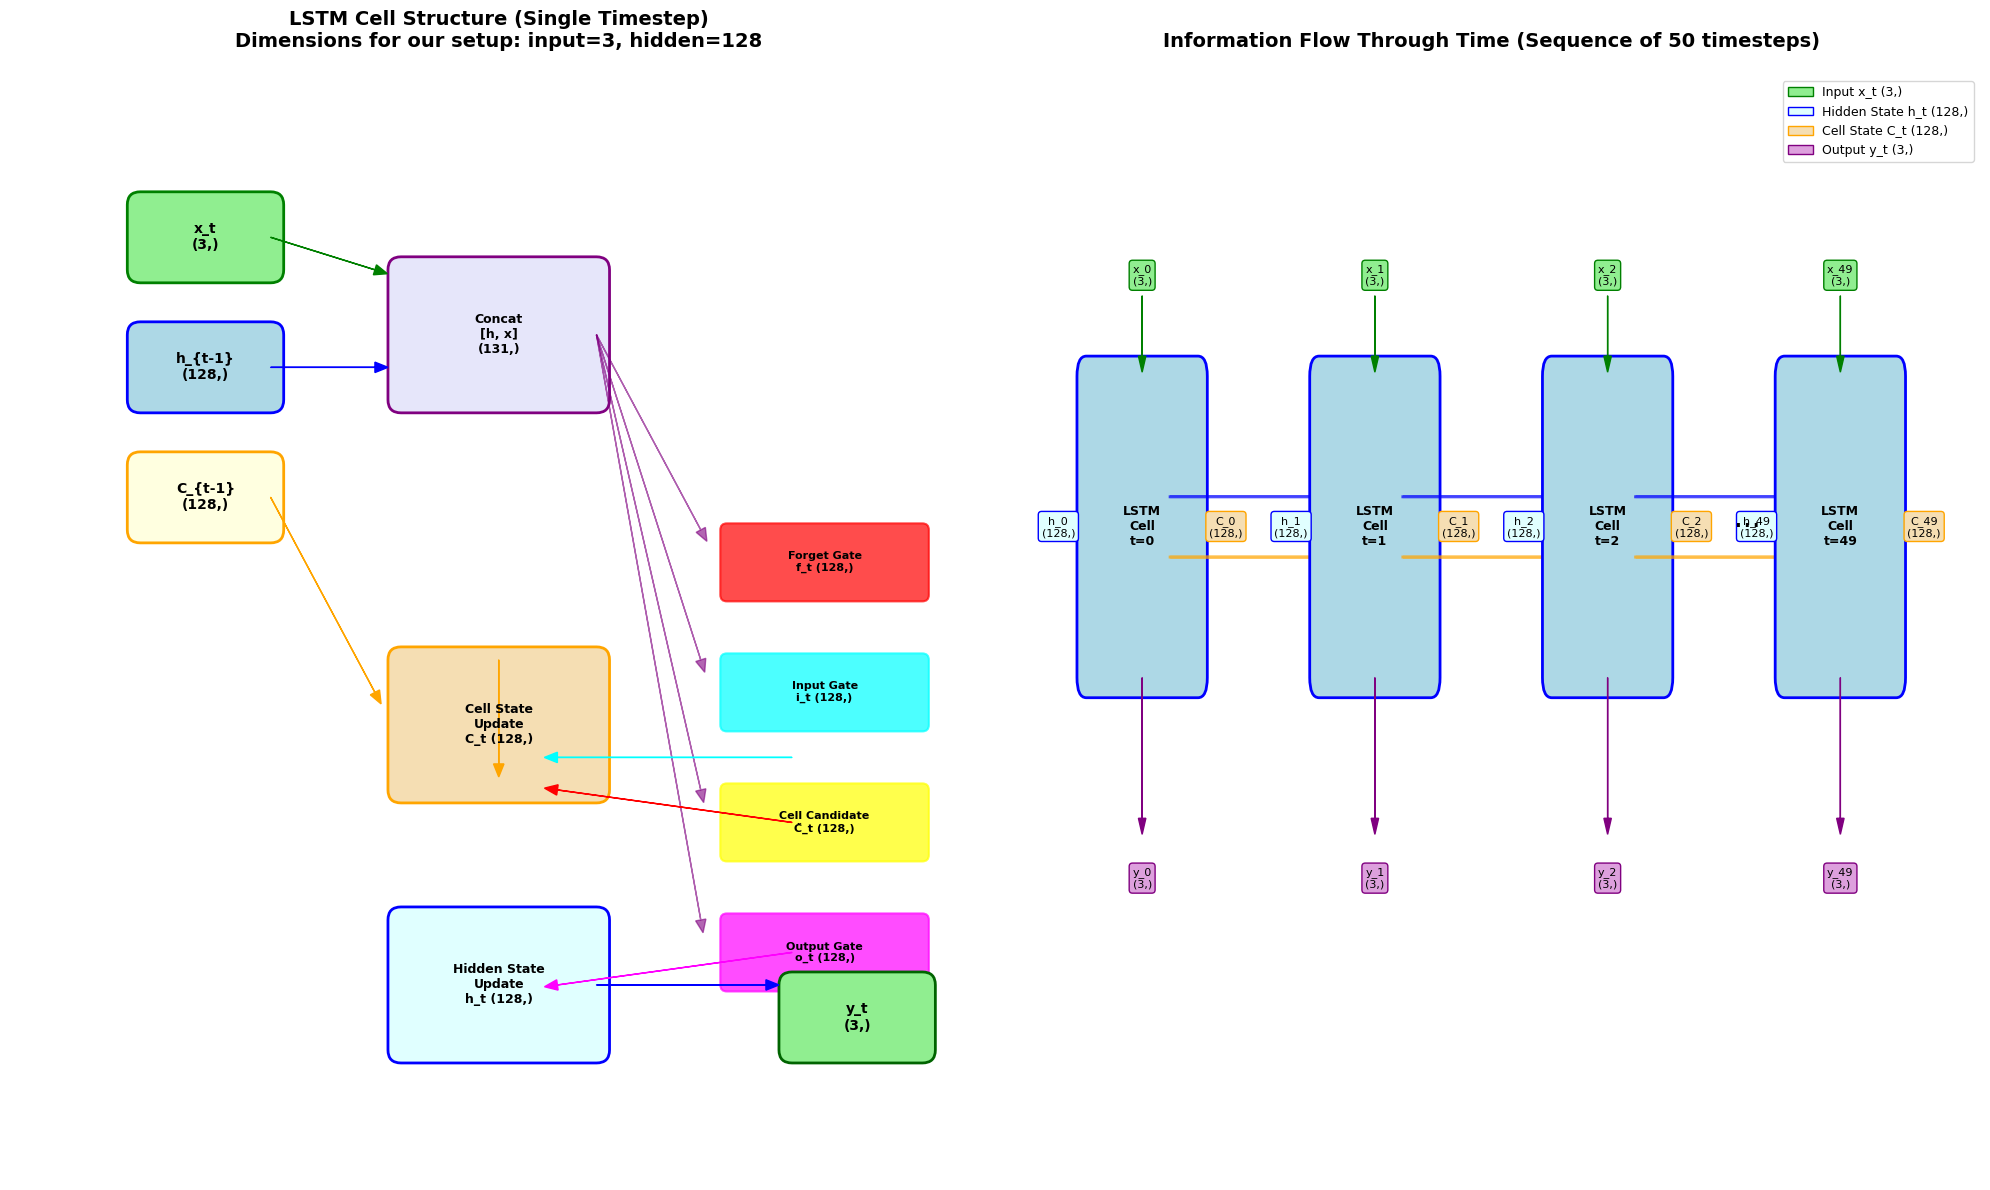


KEY INSIGHTS FROM THE VISUALIZATION:

1. SINGLE CELL (Left):
   - Input x_t (3,) combines with previous hidden state h_{t-1} (128,)
   - Concatenated to form [h, x] (131,)
   - Four gates process this: Forget, Input, Cell Candidate, Output
   - Cell state C_t (128,) flows mostly unchanged (long-term memory)
   - Hidden state h_t (128,) is computed from cell state (short-term memory)
   - Output y_t (3,) is computed from hidden state

2. UNROLLED THROUGH TIME (Right):
   - Shows how LSTM processes a sequence of 50 timesteps
   - Cell state C_t (128,) flows horizontally through time (conveyor belt)
   - Hidden state h_t (128,) flows horizontally through time
   - Each cell uses previous h_{t-1} and C_{t-1}
   - Output y_t (3,) is produced at each timestep

3. MEMORY FLOW:
   - C_0 → C_1 → C_2 → ... → C_49 (cell state flows through time)
   - h_0 → h_1 → h_2 → ... → h_49 (hidden state flows through time)
   - Each C_t and h_t carries information from ALL previous timesteps
   - This is h

In [17]:
# ============================================================================
# LSTM FORWARD PASS VISUALIZATION
# ============================================================================
# Create a visual diagram showing LSTM cell structure and information flow
# ============================================================================

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch, Circle, Rectangle

# Create figure with two subplots
fig = plt.figure(figsize=(20, 12))

# Part 1: Single LSTM Cell Structure (Left)
ax1 = plt.subplot(1, 2, 1)
ax1.set_xlim(-0.5, 7)
ax1.set_ylim(-0.5, 8)
ax1.axis('off')
ax1.set_title('LSTM Cell Structure (Single Timestep)\nDimensions for our setup: input=3, hidden=128', 
              fontsize=14, fontweight='bold', pad=20)

# Input x_t
x_box = FancyBboxPatch((0.5, 6.5), 1, 0.5, boxstyle="round,pad=0.1", 
                       edgecolor='green', facecolor='lightgreen', linewidth=2)
ax1.add_patch(x_box)
ax1.text(1, 6.75, 'x_t\n(3,)', ha='center', va='center', fontsize=10, fontweight='bold')

# Previous hidden state h_{t-1}
h_prev_box = FancyBboxPatch((0.5, 5.5), 1, 0.5, boxstyle="round,pad=0.1", 
                            edgecolor='blue', facecolor='lightblue', linewidth=2)
ax1.add_patch(h_prev_box)
ax1.text(1, 5.75, 'h_{t-1}\n(128,)', ha='center', va='center', fontsize=10, fontweight='bold')

# Previous cell state C_{t-1}
C_prev_box = FancyBboxPatch((0.5, 4.5), 1, 0.5, boxstyle="round,pad=0.1", 
                            edgecolor='orange', facecolor='lightyellow', linewidth=2)
ax1.add_patch(C_prev_box)
ax1.text(1, 4.75, 'C_{t-1}\n(128,)', ha='center', va='center', fontsize=10, fontweight='bold')

# Concatenation
concat_box = FancyBboxPatch((2.5, 5.5), 1.5, 1, boxstyle="round,pad=0.1", 
                            edgecolor='purple', facecolor='lavender', linewidth=2)
ax1.add_patch(concat_box)
ax1.text(3.25, 6, 'Concat\n[h, x]\n(131,)', ha='center', va='center', fontsize=9, fontweight='bold')

# Arrows to concatenation
ax1.arrow(1.5, 6.75, 0.8, -0.25, head_width=0.08, head_length=0.1, fc='green', ec='green')
ax1.arrow(1.5, 5.75, 0.8, 0, head_width=0.08, head_length=0.1, fc='blue', ec='blue')

# Gates (vertical stack)
gate_y_positions = [4, 3, 2, 1]
gate_names = ['Forget Gate\nf_t (128,)', 'Input Gate\ni_t (128,)', 'Cell Candidate\nC̃_t (128,)', 'Output Gate\no_t (128,)']
gate_colors = ['red', 'cyan', 'yellow', 'magenta']

for i, (y_pos, name, color) in enumerate(zip(gate_y_positions, gate_names, gate_colors)):
    gate_box = FancyBboxPatch((5, y_pos), 1.5, 0.5, boxstyle="round,pad=0.05", 
                             edgecolor=color, facecolor=color, linewidth=1.5, alpha=0.7)
    ax1.add_patch(gate_box)
    ax1.text(5.75, y_pos + 0.25, name, ha='center', va='center', fontsize=8, fontweight='bold')
    
    # Arrow from concat to gate
    ax1.arrow(4, 6, 0.8, y_pos - 5.5, head_width=0.08, head_length=0.1, 
              fc='purple', ec='purple', alpha=0.6)

# Cell State Update
C_update_box = FancyBboxPatch((2.5, 2.5), 1.5, 1, boxstyle="round,pad=0.1", 
                              edgecolor='orange', facecolor='wheat', linewidth=2)
ax1.add_patch(C_update_box)
ax1.text(3.25, 3, 'Cell State\nUpdate\nC_t (128,)', ha='center', va='center', fontsize=9, fontweight='bold')

# Arrows to cell state update
ax1.arrow(5.5, 2.25, -1.8, 0.25, head_width=0.08, head_length=0.1, fc='red', ec='red')
ax1.arrow(5.5, 2.75, -1.8, 0, head_width=0.08, head_length=0.1, fc='cyan', ec='cyan')
ax1.arrow(1.5, 4.75, 0.8, -1.5, head_width=0.08, head_length=0.1, fc='orange', ec='orange')

# Hidden State Update
h_update_box = FancyBboxPatch((2.5, 0.5), 1.5, 1, boxstyle="round,pad=0.1", 
                              edgecolor='blue', facecolor='lightcyan', linewidth=2)
ax1.add_patch(h_update_box)
ax1.text(3.25, 1, 'Hidden State\nUpdate\nh_t (128,)', ha='center', va='center', fontsize=9, fontweight='bold')

# Arrows to hidden state
ax1.arrow(5.5, 1.25, -1.8, -0.25, head_width=0.08, head_length=0.1, fc='magenta', ec='magenta')
ax1.arrow(3.25, 3.5, 0, -0.8, head_width=0.08, head_length=0.1, fc='orange', ec='orange')

# Output
y_box = FancyBboxPatch((5.5, 0.5), 1, 0.5, boxstyle="round,pad=0.1", 
                       edgecolor='darkgreen', facecolor='lightgreen', linewidth=2)
ax1.add_patch(y_box)
ax1.text(6, 0.75, 'y_t\n(3,)', ha='center', va='center', fontsize=10, fontweight='bold')

# Arrow from hidden state to output
ax1.arrow(4, 1, 1.3, 0, head_width=0.08, head_length=0.1, fc='blue', ec='blue')

# Part 2: Information Flow Through Time (Right)
ax2 = plt.subplot(1, 2, 2)
ax2.set_xlim(-0.5, 10)
ax2.set_ylim(-0.5, 5)
ax2.axis('off')
ax2.set_title('Information Flow Through Time (Sequence of 50 timesteps)', 
              fontsize=14, fontweight='bold', pad=20)

# Show first 3 timesteps and last timestep
timesteps = [0, 1, 2, 49]
x_positions = [1, 3.5, 6, 8.5]

for i, (t, x_pos) in enumerate(zip(timesteps, x_positions)):
    # LSTM Cell box
    cell_box = FancyBboxPatch((x_pos-0.6, 2), 1.2, 1.5, boxstyle="round,pad=0.1", 
                              edgecolor='blue', facecolor='lightblue', linewidth=2)
    ax2.add_patch(cell_box)
    ax2.text(x_pos, 2.75, f'LSTM\nCell\nt={t}', ha='center', va='center', 
             fontsize=9, fontweight='bold')
    
    # Input
    ax2.text(x_pos, 4, f'x_{t}\n(3,)', ha='center', va='center', fontsize=8,
             bbox=dict(boxstyle='round', facecolor='lightgreen', edgecolor='green'))
    
    # Hidden state (left side)
    ax2.text(x_pos-0.9, 2.75, f'h_{t}\n(128,)', ha='center', va='center', fontsize=8,
             bbox=dict(boxstyle='round', facecolor='lightcyan', edgecolor='blue'))
    
    # Cell state (right side)
    ax2.text(x_pos+0.9, 2.75, f'C_{t}\n(128,)', ha='center', va='center', fontsize=8,
             bbox=dict(boxstyle='round', facecolor='wheat', edgecolor='orange'))
    
    # Output
    ax2.text(x_pos, 1, f'y_{t}\n(3,)', ha='center', va='center', fontsize=8,
             bbox=dict(boxstyle='round', facecolor='plum', edgecolor='purple'))
    
    # Arrows
    if t < 49:
        # Horizontal arrows showing flow
        next_x = x_positions[i+1] if i < len(x_positions)-1 else x_pos + 2
        # Hidden state flow
        ax2.arrow(x_pos+0.3, 2.9, next_x - x_pos - 0.6, 0, head_width=0.1, head_length=0.15, 
                  fc='blue', ec='blue', linewidth=2, alpha=0.7)
        # Cell state flow
        ax2.arrow(x_pos+0.3, 2.6, next_x - x_pos - 0.6, 0, head_width=0.1, head_length=0.15, 
                  fc='orange', ec='orange', linewidth=2, alpha=0.7)
    
    # Vertical arrows within cell
    ax2.arrow(x_pos, 3.9, 0, -0.3, head_width=0.08, head_length=0.08, fc='green', ec='green')
    ax2.arrow(x_pos, 2, 0, -0.7, head_width=0.08, head_length=0.08, fc='purple', ec='purple')

# Add "..."
ax2.text(7.5, 2.75, '...', fontsize=20, ha='center')

# Add legend
legend_elements = [
    plt.Rectangle((0,0),1,1, facecolor='lightgreen', edgecolor='green', label='Input x_t (3,)'),
    plt.Rectangle((0,0),1,1, facecolor='lightcyan', edgecolor='blue', label='Hidden State h_t (128,)'),
    plt.Rectangle((0,0),1,1, facecolor='wheat', edgecolor='orange', label='Cell State C_t (128,)'),
    plt.Rectangle((0,0),1,1, facecolor='plum', edgecolor='purple', label='Output y_t (3,)'),
]
ax2.legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

# Additional text explanation
print("\n" + "="*70)
print("KEY INSIGHTS FROM THE VISUALIZATION:")
print("="*70)
print("\n1. SINGLE CELL (Left):")
print("   - Input x_t (3,) combines with previous hidden state h_{t-1} (128,)")
print("   - Concatenated to form [h, x] (131,)")
print("   - Four gates process this: Forget, Input, Cell Candidate, Output")
print("   - Cell state C_t (128,) flows mostly unchanged (long-term memory)")
print("   - Hidden state h_t (128,) is computed from cell state (short-term memory)")
print("   - Output y_t (3,) is computed from hidden state")
print("\n2. UNROLLED THROUGH TIME (Right):")
print("   - Shows how LSTM processes a sequence of 50 timesteps")
print("   - Cell state C_t (128,) flows horizontally through time (conveyor belt)")
print("   - Hidden state h_t (128,) flows horizontally through time")
print("   - Each cell uses previous h_{t-1} and C_{t-1}")
print("   - Output y_t (3,) is produced at each timestep")
print("\n3. MEMORY FLOW:")
print("   - C_0 → C_1 → C_2 → ... → C_49 (cell state flows through time)")
print("   - h_0 → h_1 → h_2 → ... → h_49 (hidden state flows through time)")
print("   - Each C_t and h_t carries information from ALL previous timesteps")
print("   - This is how LSTM 'remembers' long-term patterns!")
print("="*70)


In [22]:
# ============================================================================
# LSTM FORWARD PASS IMPLEMENTATION
# ============================================================================
# Add forward pass method to LSTM class
# ============================================================================

def forward(self, X):
    """
    Forward pass through LSTM.
    
    Args:
        X: Input sequences of shape (batch_size, sequence_length, input_size)
           or (sequence_length, input_size) for single sequence
    
    Returns:
        outputs: Output predictions at each timestep, shape (batch_size, sequence_length, output_size)
        hidden_states: Hidden states at each timestep, shape (batch_size, sequence_length+1, hidden_size)
        cell_states: Cell states at each timestep, shape (batch_size, sequence_length+1, hidden_size)
        gates: Dictionary containing all gate values for backward pass
    """
    # Handle single sequence input (add batch dimension)
    if X.ndim == 2:
        X = X[np.newaxis, :, :]  # Add batch dimension: (seq_len, input_size) -> (1, seq_len, input_size)
        squeeze_output = True
    else:
        squeeze_output = False
    
    batch_size, seq_length, input_size = X.shape
    
    # Verify input size matches
    assert input_size == self.input_size, f"Input size mismatch: expected {self.input_size}, got {input_size}"
    
    # Initialize hidden state and cell state (both start at zero)
    # Shape: (batch_size, hidden_size)
    h = np.zeros((batch_size, self.hidden_size))
    C = np.zeros((batch_size, self.hidden_size))
    
    # Store all intermediate values for backward pass
    hidden_states = [h.copy()]  # Include initial h_0
    cell_states = [C.copy()]    # Include initial C_0
    
    # Store gate values for backward pass
    forget_gates = []
    input_gates = []
    cell_candidates = []
    output_gates = []
    concatenated_inputs = []  # Store [h_{t-1}, x_t] for each timestep
    
    # Store outputs at each timestep
    outputs = []
    
    # Process each timestep in the sequence
    for t in range(seq_length):
        # Get input at current timestep
        # Shape: (batch_size, input_size)
        x_t = X[:, t, :]
        
        # ====================================================================
        # LSTM CELL COMPUTATIONS
        # ====================================================================
        # Step 1: Concatenate previous hidden state and current input
        # Shape: (batch_size, input_size + hidden_size)
        concat_input = np.concatenate([h, x_t], axis=1)
        concatenated_inputs.append(concat_input.copy())
        
        # Step 2: Forget Gate
        # f_t = σ(W_f · [h_{t-1}, x_t] + b_f)
        # Shape: (batch_size, hidden_size)
        f_t = self._sigmoid(np.dot(concat_input, self.W_f) + self.b_f)
        forget_gates.append(f_t.copy())
        
        # Step 3: Input Gate
        # i_t = σ(W_i · [h_{t-1}, x_t] + b_i)
        # Shape: (batch_size, hidden_size)
        i_t = self._sigmoid(np.dot(concat_input, self.W_i) + self.b_i)
        input_gates.append(i_t.copy())
        
        # Step 4: Cell Candidate
        # C̃_t = tanh(W_C · [h_{t-1}, x_t] + b_C)
        # Shape: (batch_size, hidden_size)
        C_tilde = np.tanh(np.dot(concat_input, self.W_C) + self.b_C)
        cell_candidates.append(C_tilde.copy())
        
        # Step 5: Update Cell State
        # C_t = f_t ⊙ C_{t-1} + i_t ⊙ C̃_t
        # ⊙ = element-wise multiplication (Hadamard product)
        # Shape: (batch_size, hidden_size)
        C = f_t * C + i_t * C_tilde
        cell_states.append(C.copy())
        
        # Step 6: Output Gate
        # o_t = σ(W_o · [h_{t-1}, x_t] + b_o)
        # Shape: (batch_size, hidden_size)
        o_t = self._sigmoid(np.dot(concat_input, self.W_o) + self.b_o)
        output_gates.append(o_t.copy())
        
        # Step 7: Update Hidden State
        # h_t = o_t ⊙ tanh(C_t)
        # Shape: (batch_size, hidden_size)
        h = o_t * np.tanh(C)
        hidden_states.append(h.copy())
        
        # Step 8: Compute Output
        # y_t = W_hy · h_t + b_y
        # Shape: (batch_size, output_size)
        y_t = np.dot(h, self.W_hy) + self.b_y
        outputs.append(y_t.copy())
    
    # Convert lists to numpy arrays
    # Shape: (batch_size, sequence_length, output_size)
    outputs = np.array(outputs).transpose(1, 0, 2)
    
    # Shape: (batch_size, sequence_length+1, hidden_size)
    hidden_states = np.array(hidden_states).transpose(1, 0, 2)
    cell_states = np.array(cell_states).transpose(1, 0, 2)
    
    # Store gates for backward pass
    gates = {
        'forget': np.array(forget_gates).transpose(1, 0, 2),  # (batch_size, seq_length, hidden_size)
        'input': np.array(input_gates).transpose(1, 0, 2),
        'cell_candidate': np.array(cell_candidates).transpose(1, 0, 2),
        'output': np.array(output_gates).transpose(1, 0, 2),
        'concatenated_inputs': np.array(concatenated_inputs).transpose(1, 0, 2)  # (batch_size, seq_length, input_size+hidden_size)
    }
    
    # Remove batch dimension if input was single sequence
    if squeeze_output:
        outputs = outputs.squeeze(0)
        hidden_states = hidden_states.squeeze(0)
        cell_states = cell_states.squeeze(0)
        for key in gates:
            gates[key] = gates[key].squeeze(0)
    
    return outputs, hidden_states, cell_states, gates

def _sigmoid(self, x):
    """
    Sigmoid activation function: σ(x) = 1 / (1 + exp(-x))
    
    Args:
        x: Input array
    
    Returns:
        Sigmoid of input
    """
    # Clip x to prevent overflow in exp(-x)
    x_clipped = np.clip(x, -500, 500)
    return 1.0 / (1.0 + np.exp(-x_clipped))

# Add methods to LSTM class
LSTM.forward = forward
LSTM._sigmoid = _sigmoid

print("="*60)
print("LSTM Forward Pass Method Added")
print("="*60)
print("✓ forward() method implemented")
print("✓ _sigmoid() helper method implemented")
print("\nThe forward pass:")
print("  - Processes sequences through LSTM cell timestep by timestep")
print("  - Computes all gates (forget, input, output)")
print("  - Updates cell state and hidden state")
print("  - Produces outputs at each timestep")
print("  - Stores intermediate values for backward pass")
print("\n" + "="*60)


LSTM Forward Pass Method Added
✓ forward() method implemented
✓ _sigmoid() helper method implemented

The forward pass:
  - Processes sequences through LSTM cell timestep by timestep
  - Computes all gates (forget, input, output)
  - Updates cell state and hidden state
  - Produces outputs at each timestep
  - Stores intermediate values for backward pass



In [23]:
# Test the forward pass with a single sequence
print("="*60)
print("Testing LSTM Forward Pass")
print("="*60)

# Test with first training sequence
test_sequence = X_train[0]  # Shape: (50, 3) - 50 timesteps, 3 features
print(f"Test sequence shape: {test_sequence.shape}")
print(f"  - {test_sequence.shape[0]} timesteps")
print(f"  - {test_sequence.shape[1]} features (RPM, Speed, MAP)")

# Run forward pass
outputs, hidden_states, cell_states, gates = lstm.forward(test_sequence)

print("\n" + "="*60)
print("Forward Pass Results")
print("="*60)
print(f"Outputs shape: {outputs.shape}")
print(f"  - {outputs.shape[0]} timesteps")
print(f"  - {outputs.shape[1]} predictions (RPM, Speed, MAP)")
print(f"\nHidden states shape: {hidden_states.shape}")
print(f"  - {hidden_states.shape[0]} timesteps (including initial h_0)")
print(f"  - {hidden_states.shape[1]} hidden units")
print(f"\nCell states shape: {cell_states.shape}")
print(f"  - {cell_states.shape[0]} timesteps (including initial C_0)")
print(f"  - {cell_states.shape[1]} cell units")

print("\n" + "="*60)
print("Gate Values (First Timestep)")
print("="*60)
print(f"Forget gate (f_0): {gates['forget'][0][:5]}... (showing first 5 values)")
print(f"Input gate (i_0): {gates['input'][0][:5]}... (showing first 5 values)")
print(f"Output gate (o_0): {gates['output'][0][:5]}... (showing first 5 values)")
print(f"\nCell state (C_0): {cell_states[0][:5]}... (showing first 5 values)")
print(f"Hidden state (h_0): {hidden_states[0][:5]}... (showing first 5 values)")
print(f"Output (y_0): {outputs[0]}")

print("\n" + "="*60)
print("Gate Values (Last Timestep)")
print("="*60)
t_last = len(gates['forget']) - 1
print(f"Forget gate (f_{t_last}): {gates['forget'][t_last][:5]}... (showing first 5 values)")
print(f"Input gate (i_{t_last}): {gates['input'][t_last][:5]}... (showing first 5 values)")
print(f"Output gate (o_{t_last}): {gates['output'][t_last][:5]}... (showing first 5 values)")
print(f"\nCell state (C_{t_last}): {cell_states[t_last+1][:5]}... (showing first 5 values)")
print(f"Hidden state (h_{t_last}): {hidden_states[t_last+1][:5]}... (showing first 5 values)")
print(f"Output (y_{t_last}): {outputs[t_last]}")

print("\n" + "="*60)
print("✓ Forward Pass Test Complete!")
print("="*60)
print("The LSTM is processing sequences correctly.")
print("Next step: Implement backward pass (BPTT) for training.")
print("="*60)


Testing LSTM Forward Pass
Test sequence shape: (50, 3)
  - 50 timesteps
  - 3 features (RPM, Speed, MAP)

Forward Pass Results
Outputs shape: (50, 3)
  - 50 timesteps
  - 3 predictions (RPM, Speed, MAP)

Hidden states shape: (51, 128)
  - 51 timesteps (including initial h_0)
  - 128 hidden units

Cell states shape: (51, 128)
  - 51 timesteps (including initial C_0)
  - 128 cell units

Gate Values (First Timestep)
Forget gate (f_0): [0.49633849 0.49011035 0.50333588 0.49327332 0.51417353]... (showing first 5 values)
Input gate (i_0): [0.50644408 0.50581339 0.51784538 0.49540356 0.49209988]... (showing first 5 values)
Output gate (o_0): [0.50265888 0.48605546 0.51334485 0.5078559  0.50949747]... (showing first 5 values)

Cell state (C_0): [0. 0. 0. 0. 0.]... (showing first 5 values)
Hidden state (h_0): [0. 0. 0. 0. 0.]... (showing first 5 values)
Output (y_0): [ 0.01728935 -0.00127425  0.01380928]

Gate Values (Last Timestep)
Forget gate (f_49): [0.49926603 0.48988663 0.50345983 0.499873

## Step 8: LSTM Backward Pass (BPTT) Implementation

Backpropagation Through Time (BPTT) calculates gradients for all LSTM parameters. This is more complex than vanilla RNN because we have:

1. **Cell state gradients** that flow through time (like a conveyor belt)
2. **Hidden state gradients** that flow through time
3. **Gate gradients** (forget, input, output, cell candidate)
4. **Output layer gradients**

### Key Differences from Vanilla RNN

**Vanilla RNN:**
- Only hidden state flows through time
- Gradients: ∂Loss/∂W_hh, ∂Loss/∂W_xh, ∂Loss/∂W_hy

**LSTM:**
- Both cell state AND hidden state flow through time
- Gradients flow through cell state (mostly unchanged - this is the key!)
- More gates = more parameters to update
- Cell state gradient flow prevents vanishing gradients

### Backward Pass Overview

We need to compute gradients for:
- All gate weights: W_f, W_i, W_C, W_o
- All gate biases: b_f, b_i, b_C, b_o
- Output layer: W_hy, b_y

Gradients flow backward through:
1. Output layer (y_t → h_t)
2. Hidden state (h_t → h_{t-1}, C_t)
3. Cell state (C_t → C_{t-1})
4. Gates (f_t, i_t, C̃_t, o_t)


In [24]:
# ============================================================================
# LSTM BACKWARD PASS (BPTT) IMPLEMENTATION
# ============================================================================
# Implement backpropagation through time for LSTM
# ============================================================================

def backward(self, X, hidden_states, cell_states, gates, d_outputs):
    """
    Backward pass through LSTM (Backpropagation Through Time).
    
    Args:
        X: Input sequences, shape (batch_size, sequence_length, input_size)
        hidden_states: Hidden states from forward pass, shape (batch_size, sequence_length+1, hidden_size)
        cell_states: Cell states from forward pass, shape (batch_size, sequence_length+1, hidden_size)
        gates: Dictionary with gate values from forward pass
        d_outputs: Gradients w.r.t. outputs, shape (batch_size, sequence_length, output_size)
    
    Returns:
        gradients: Dictionary containing gradients for all parameters
        d_X: Gradients w.r.t. input (optional, for multi-layer LSTM)
    """
    batch_size, seq_length, input_size = X.shape
    
    # Handle single sequence input
    if X.ndim == 2:
        X = X[np.newaxis, :, :]
        hidden_states = hidden_states[np.newaxis, :, :]
        cell_states = cell_states[np.newaxis, :, :]
        d_outputs = d_outputs[np.newaxis, :, :]
        for key in gates:
            gates[key] = gates[key][np.newaxis, :, :]
        squeeze_output = True
    else:
        squeeze_output = False
    
    # Initialize gradient accumulators
    dW_f = np.zeros_like(self.W_f)
    db_f = np.zeros_like(self.b_f)
    dW_i = np.zeros_like(self.W_i)
    db_i = np.zeros_like(self.b_i)
    dW_C = np.zeros_like(self.W_C)
    db_C = np.zeros_like(self.b_C)
    dW_o = np.zeros_like(self.W_o)
    db_o = np.zeros_like(self.b_o)
    dW_hy = np.zeros_like(self.W_hy)
    db_y = np.zeros_like(self.b_y)
    
    # Gradients for hidden state and cell state (flow backward through time)
    dh_next = np.zeros((batch_size, self.hidden_size))
    dC_next = np.zeros((batch_size, self.hidden_size))
    
    # Extract gate values
    forget_gates = gates['forget']  # (batch_size, seq_length, hidden_size)
    input_gates = gates['input']
    cell_candidates = gates['cell_candidate']
    output_gates = gates['output']
    concat_inputs = gates['concatenated_inputs']  # (batch_size, seq_length, input_size+hidden_size)
    
    # Process backward through time (from last timestep to first)
    for t in range(seq_length - 1, -1, -1):
        # Get values at timestep t
        h_t = hidden_states[:, t + 1, :]  # Hidden state at timestep t
        h_prev = hidden_states[:, t, :]   # Previous hidden state
        C_t = cell_states[:, t + 1, :]     # Cell state at timestep t
        C_prev = cell_states[:, t, :]      # Previous cell state
        
        f_t = forget_gates[:, t, :]
        i_t = input_gates[:, t, :]
        C_tilde_t = cell_candidates[:, t, :]
        o_t = output_gates[:, t, :]
        concat_t = concat_inputs[:, t, :]
        
        # Gradient from output layer
        dy_t = d_outputs[:, t, :]  # Gradient w.r.t. output at timestep t
        
        # Gradient w.r.t. hidden state from output layer
        # y_t = W_hy · h_t + b_y, so ∂Loss/∂h_t += W_hy^T · ∂Loss/∂y_t
        dh_t = np.dot(dy_t, self.W_hy.T) + dh_next
        
        # Gradient w.r.t. output layer weights
        dW_hy += np.dot(h_t.T, dy_t)
        db_y += np.sum(dy_t, axis=0)
        
        # ====================================================================
        # GRADIENTS FOR HIDDEN STATE AND CELL STATE
        # ====================================================================
        # h_t = o_t ⊙ tanh(C_t)
        # So: ∂h_t/∂C_t = o_t ⊙ (1 - tanh²(C_t))
        tanh_C_t = np.tanh(C_t)
        dC_t = dh_t * o_t * (1 - tanh_C_t ** 2) + dC_next
        
        # ====================================================================
        # GRADIENTS FOR CELL STATE UPDATE
        # ====================================================================
        # C_t = f_t ⊙ C_{t-1} + i_t ⊙ C̃_t
        # So:
        # ∂C_t/∂f_t = C_{t-1}
        # ∂C_t/∂i_t = C̃_t
        # ∂C_t/∂C̃_t = i_t
        # ∂C_t/∂C_{t-1} = f_t
        
        df_t = dC_t * C_prev
        di_t = dC_t * C_tilde_t
        dC_tilde_t = dC_t * i_t
        dC_prev = dC_t * f_t
        
        # ====================================================================
        # GRADIENTS FOR GATES
        # ====================================================================
        # All gates use sigmoid: σ(x), so derivative is σ(x) * (1 - σ(x))
        # f_t = σ(W_f · concat_t + b_f)
        df_t_sigmoid = df_t * f_t * (1 - f_t)
        dW_f += np.dot(concat_t.T, df_t_sigmoid)
        db_f += np.sum(df_t_sigmoid, axis=0)
        
        # i_t = σ(W_i · concat_t + b_i)
        di_t_sigmoid = di_t * i_t * (1 - i_t)
        dW_i += np.dot(concat_t.T, di_t_sigmoid)
        db_i += np.sum(di_t_sigmoid, axis=0)
        
        # C̃_t = tanh(W_C · concat_t + b_C)
        dC_tilde_t_tanh = dC_tilde_t * (1 - C_tilde_t ** 2)
        dW_C += np.dot(concat_t.T, dC_tilde_t_tanh)
        db_C += np.sum(dC_tilde_t_tanh, axis=0)
        
        # o_t = σ(W_o · concat_t + b_o)
        # h_t = o_t ⊙ tanh(C_t), so ∂h_t/∂o_t = tanh(C_t)
        do_t = dh_t * tanh_C_t
        do_t_sigmoid = do_t * o_t * (1 - o_t)
        dW_o += np.dot(concat_t.T, do_t_sigmoid)
        db_o += np.sum(do_t_sigmoid, axis=0)
        
        # ====================================================================
        # GRADIENTS FOR CONCATENATED INPUT
        # ====================================================================
        # concat_t = [h_{t-1}, x_t]
        # We need to compute gradient w.r.t. concat_t and split it
        dconcat_t = (np.dot(df_t_sigmoid, self.W_f.T) +
                     np.dot(di_t_sigmoid, self.W_i.T) +
                     np.dot(dC_tilde_t_tanh, self.W_C.T) +
                     np.dot(do_t_sigmoid, self.W_o.T))
        
        # Split gradient: dconcat_t = [dh_{t-1}, dx_t]
        dh_prev_from_concat = dconcat_t[:, :self.hidden_size]
        dx_t = dconcat_t[:, self.hidden_size:]
        
        # Update gradients for next iteration (backward through time)
        dh_next = dh_prev_from_concat
        dC_next = dC_prev
    
    # Store all gradients in dictionary
    gradients = {
        'W_f': dW_f, 'b_f': db_f,
        'W_i': dW_i, 'b_i': db_i,
        'W_C': dW_C, 'b_C': db_C,
        'W_o': dW_o, 'b_o': db_o,
        'W_hy': dW_hy, 'b_y': db_y
    }
    
    return gradients

# Add backward method to LSTM class
LSTM.backward = backward

print("="*60)
print("LSTM Backward Pass Method Added")
print("="*60)
print("✓ backward() method implemented")
print("\nThe backward pass:")
print("  - Computes gradients for all gates (forget, input, output, cell candidate)")
print("  - Computes gradients for cell state and hidden state")
print("  - Flows gradients backward through time (BPTT)")
print("  - Returns gradients for all parameters")
print("\n" + "="*60)


LSTM Backward Pass Method Added
✓ backward() method implemented

The backward pass:
  - Computes gradients for all gates (forget, input, output, cell candidate)
  - Computes gradients for cell state and hidden state
  - Flows gradients backward through time (BPTT)
  - Returns gradients for all parameters



### Backward Pass Visualization (Dimensions)

**For our setup:**
- Output size = 3 (RPM, Speed, MAP)
- Hidden size = 128
- Sequence length = 50

**Backward Pass Flow (from last timestep to first):**

```
Gradient flow direction: t=49 → t=48 → ... → t=1 → t=0
```

**At Each Timestep t (Backward, from t=49 to t=0):**

```
┌─────────────────────────────────────────────────────────────┐
│              BACKWARD PASS AT TIMESTEP t                      │
└─────────────────────────────────────────────────────────────┘

INPUT (from forward pass):
  h_t: (128,)                    # Hidden state at timestep t
  C_t: (128,)                    # Cell state at timestep t
  h_{t-1}: (128,)                # Previous hidden state
  C_{t-1}: (128,)                # Previous cell state
  f_t, i_t, o_t: (128,) each     # Gate values
  C̃_t: (128,)                    # Cell candidate
  concat_t: (131,)               # [h_{t-1}, x_t]

GRADIENT INPUT:
  d_outputs[t]: (3,)              # Gradient w.r.t. output y_t
  dh_next: (128,)                # Gradient from next timestep (t+1)
  dC_next: (128,)                # Cell state gradient from next timestep

STEP 1: Output Layer Gradients
  dy_t: (3,)                     # Gradient w.r.t. output
  dh_from_output: (128,)         # ∂Loss/∂h_t from output: W_hy^T · dy_t
  dW_hy: (128, 3)                # Gradient w.r.t. output weights
  db_y: (3,)                     # Gradient w.r.t. output bias

STEP 2: Hidden State Gradient
  dh_t: (128,)                   # Total gradient w.r.t. h_t
                                  # = dh_from_output + dh_next

STEP 3: Cell State Gradient
  dC_t: (128,)                   # Gradient w.r.t. cell state
                                  # = dh_t ⊙ o_t ⊙ (1 - tanh²(C_t)) + dC_next

STEP 4: Gate Gradients
  df_t: (128,)                   # Gradient w.r.t. forget gate
  di_t: (128,)                   # Gradient w.r.t. input gate
  dC̃_t: (128,)                   # Gradient w.r.t. cell candidate
  do_t: (128,)                   # Gradient w.r.t. output gate

STEP 5: Weight Gradients
  dW_f, dW_i, dW_C, dW_o: (131, 128) each  # Gate weight gradients
  db_f, db_i, db_C, db_o: (128,) each       # Gate bias gradients

STEP 6: Propagate to Previous Timestep
  dh_{t-1}: (128,)               # Gradient for previous hidden state
  dC_{t-1}: (128,)               # Gradient for previous cell state
                                  # These flow to timestep t-1

OUTPUT:
  dh_{t-1}: (128,) → flows to timestep t-1
  dC_{t-1}: (128,) → flows to timestep t-1
  All weight/bias gradients accumulated
```

**Gradient Flow Through Time (Backward):**

```
t=49: d_outputs[49](3) → dh_49(128) → dC_49(128) → dh_48(128) + dC_48(128)
       ↓
t=48: d_outputs[48](3) + dh_49(128) → dh_48(128) → dC_48(128) → dh_47(128) + dC_47(128)
       ↓
t=47: d_outputs[47](3) + dh_48(128) → dh_47(128) → dC_47(128) → dh_46(128) + dC_46(128)
       ↓
...
       ↓
t=1:  d_outputs[1](3) + dh_2(128) → dh_1(128) → dC_1(128) → dh_0(128) + dC_0(128)
       ↓
t=0:  d_outputs[0](3) + dh_1(128) → dh_0(128) → dC_0(128) → dh_{-1}(128) + dC_{-1}(128)
```

**Key Points:**
- **Gradients flow backward**: From t=49 to t=0 (opposite of forward pass)
- **Cell state gradients**: Flow mostly unchanged (like a conveyor belt) - this prevents vanishing gradients!
- **Hidden state gradients**: Flow backward and accumulate
- **Gate gradients**: Computed using chain rule from cell state gradients
- **Weight gradients**: Accumulated across all timesteps


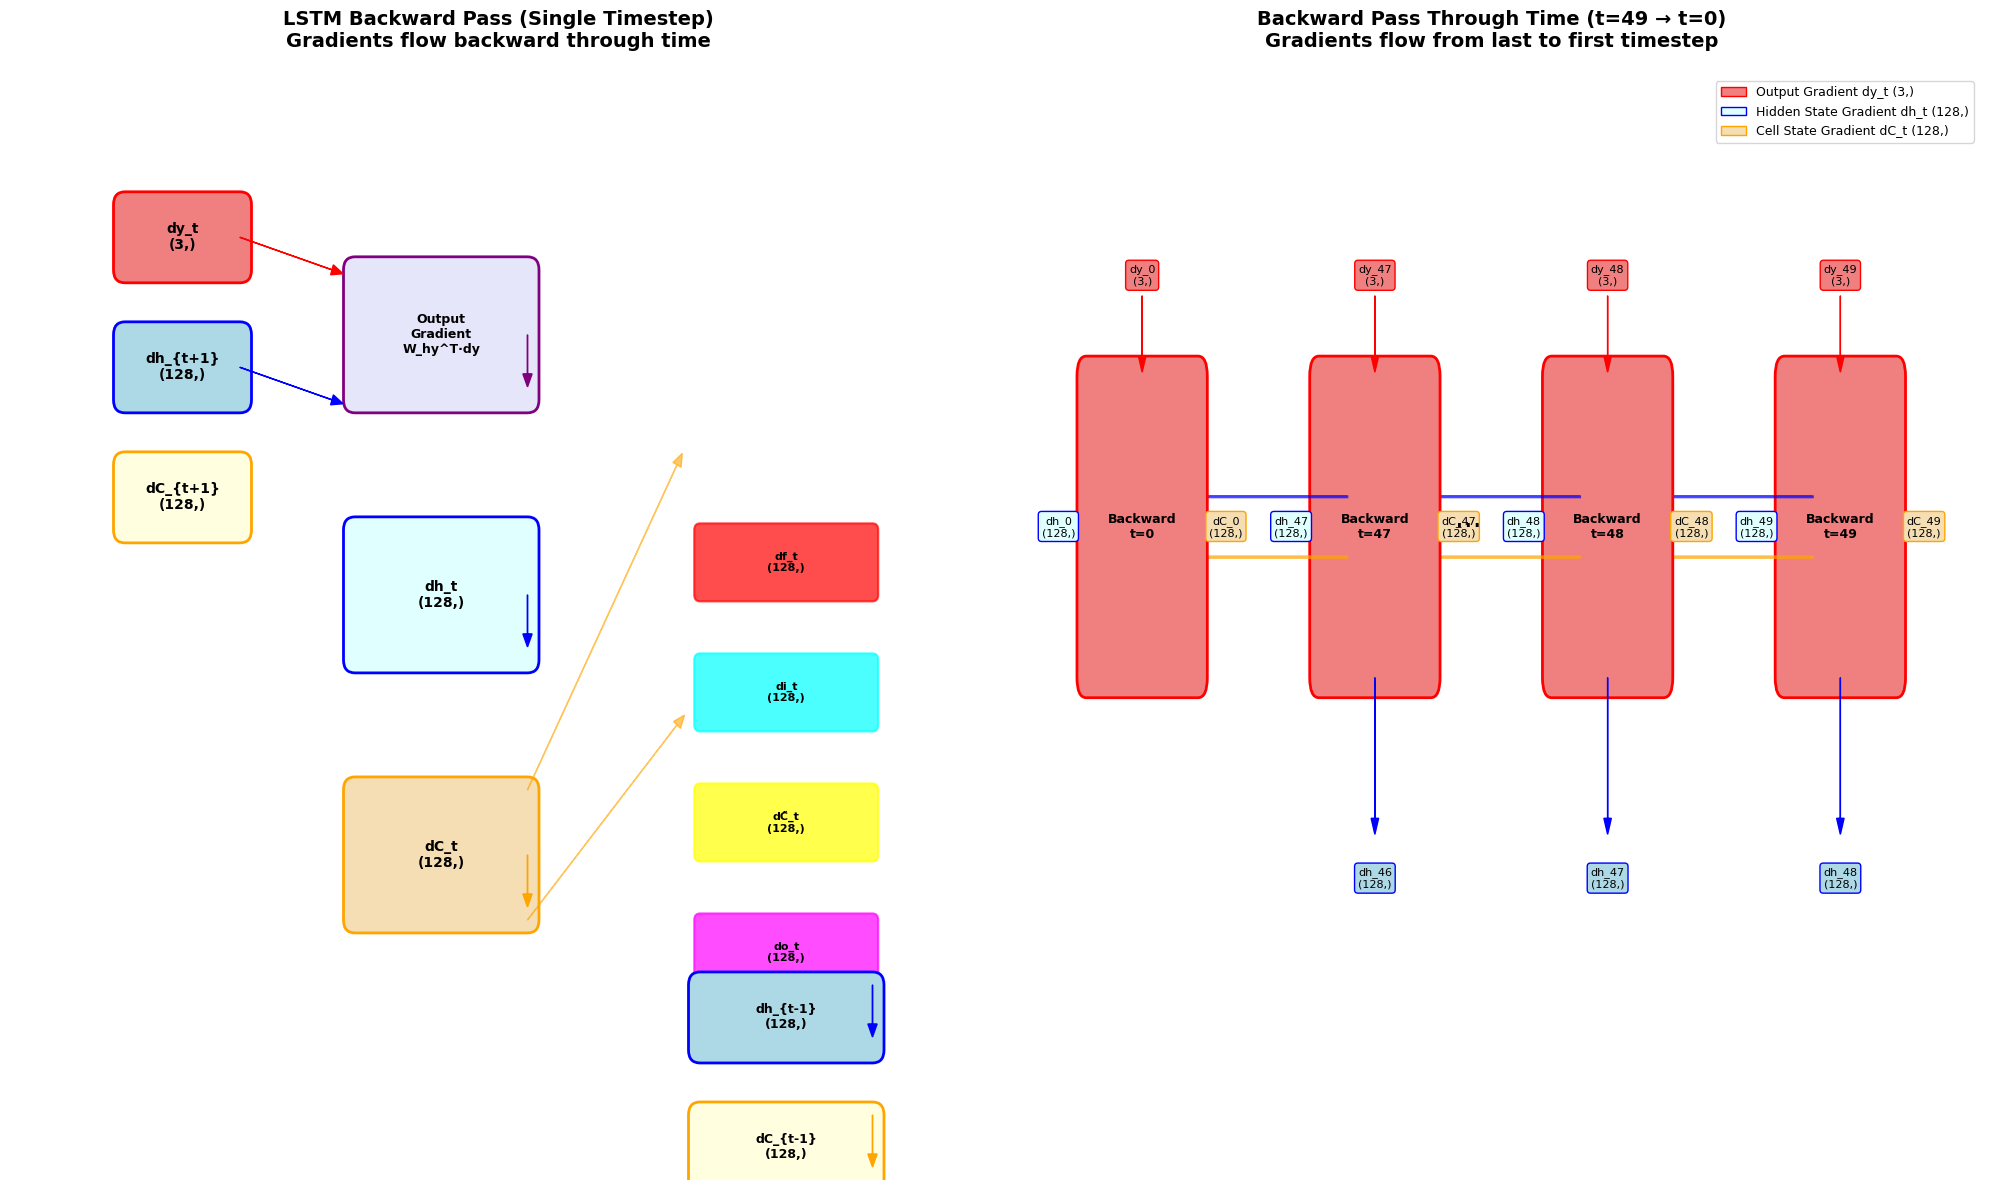


KEY INSIGHTS FROM THE BACKWARD PASS VISUALIZATION:

1. SINGLE TIMESTEP (Left):
   - Gradients flow backward: dy_t (3,) from output loss
   - Output layer gradient: W_hy^T · dy_t → dh_t (128,)
   - Hidden state gradient: dh_t = dh_from_output + dh_{t+1}
   - Cell state gradient: dC_t flows mostly unchanged (key to preventing vanishing gradients!)
   - Gate gradients: df_t, di_t, dC̃_t, do_t all (128,) dimensions
   - Previous timestep: dh_{t-1} and dC_{t-1} flow to timestep t-1

2. BACKWARD THROUGH TIME (Right):
   - Gradients flow from t=49 → t=48 → ... → t=1 → t=0
   - Cell state gradients dC_t flow backward (like a conveyor belt)
   - Hidden state gradients dh_t flow backward and accumulate
   - Each timestep computes gradients and passes them to previous timestep

3. KEY DIFFERENCE FROM VANILLA RNN:
   - Cell state gradients flow mostly unchanged through time
   - This prevents vanishing gradients (the main advantage of LSTM!)
   - Even with 50 timesteps, gradients can flow back to

In [20]:
# ============================================================================
# LSTM BACKWARD PASS VISUALIZATION
# ============================================================================
# Create a visual diagram showing backward pass gradient flow
# ============================================================================

fig = plt.figure(figsize=(20, 12))

# Part 1: Single Timestep Backward Pass (Left)
ax1 = plt.subplot(1, 2, 1)
ax1.set_xlim(-0.5, 8)
ax1.set_ylim(-0.5, 8)
ax1.axis('off')
ax1.set_title('LSTM Backward Pass (Single Timestep)\nGradients flow backward through time', 
              fontsize=14, fontweight='bold', pad=20)

# Output gradient (input to backward pass)
dy_box = FancyBboxPatch((0.5, 6.5), 1, 0.5, boxstyle="round,pad=0.1", 
                        edgecolor='red', facecolor='lightcoral', linewidth=2)
ax1.add_patch(dy_box)
ax1.text(1, 6.75, 'dy_t\n(3,)', ha='center', va='center', fontsize=10, fontweight='bold')

# Gradients from next timestep
dh_next_box = FancyBboxPatch((0.5, 5.5), 1, 0.5, boxstyle="round,pad=0.1", 
                             edgecolor='blue', facecolor='lightblue', linewidth=2)
ax1.add_patch(dh_next_box)
ax1.text(1, 5.75, 'dh_{t+1}\n(128,)', ha='center', va='center', fontsize=10, fontweight='bold')

dC_next_box = FancyBboxPatch((0.5, 4.5), 1, 0.5, boxstyle="round,pad=0.1", 
                             edgecolor='orange', facecolor='lightyellow', linewidth=2)
ax1.add_patch(dC_next_box)
ax1.text(1, 4.75, 'dC_{t+1}\n(128,)', ha='center', va='center', fontsize=10, fontweight='bold')

# Output layer gradient
output_grad_box = FancyBboxPatch((2.5, 5.5), 1.5, 1, boxstyle="round,pad=0.1", 
                                 edgecolor='purple', facecolor='lavender', linewidth=2)
ax1.add_patch(output_grad_box)
ax1.text(3.25, 6, 'Output\nGradient\nW_hy^T·dy', ha='center', va='center', fontsize=9, fontweight='bold')

# Hidden state gradient
dh_box = FancyBboxPatch((2.5, 3.5), 1.5, 1, boxstyle="round,pad=0.1", 
                        edgecolor='blue', facecolor='lightcyan', linewidth=2)
ax1.add_patch(dh_box)
ax1.text(3.25, 4, 'dh_t\n(128,)', ha='center', va='center', fontsize=10, fontweight='bold')

# Cell state gradient
dC_box = FancyBboxPatch((2.5, 1.5), 1.5, 1, boxstyle="round,pad=0.1", 
                        edgecolor='orange', facecolor='wheat', linewidth=2)
ax1.add_patch(dC_box)
ax1.text(3.25, 2, 'dC_t\n(128,)', ha='center', va='center', fontsize=10, fontweight='bold')

# Gate gradients
gate_grads = ['df_t', 'di_t', 'dC̃_t', 'do_t']
gate_y_pos = [4, 3, 2, 1]
gate_colors = ['red', 'cyan', 'yellow', 'magenta']

for i, (name, y_pos, color) in enumerate(zip(gate_grads, gate_y_pos, gate_colors)):
    gate_box = FancyBboxPatch((5.5, y_pos), 1.5, 0.5, boxstyle="round,pad=0.05", 
                              edgecolor=color, facecolor=color, linewidth=1.5, alpha=0.7)
    ax1.add_patch(gate_box)
    ax1.text(6.25, y_pos + 0.25, f'{name}\n(128,)', ha='center', va='center', 
             fontsize=8, fontweight='bold')

# Previous timestep gradients (output of backward pass)
dh_prev_box = FancyBboxPatch((5.5, 0.5), 1.5, 0.5, boxstyle="round,pad=0.1", 
                             edgecolor='blue', facecolor='lightblue', linewidth=2)
ax1.add_patch(dh_prev_box)
ax1.text(6.25, 0.75, 'dh_{t-1}\n(128,)', ha='center', va='center', fontsize=9, fontweight='bold')

dC_prev_box = FancyBboxPatch((5.5, -0.5), 1.5, 0.5, boxstyle="round,pad=0.1", 
                             edgecolor='orange', facecolor='lightyellow', linewidth=2)
ax1.add_patch(dC_prev_box)
ax1.text(6.25, -0.25, 'dC_{t-1}\n(128,)', ha='center', va='center', fontsize=9, fontweight='bold')

# Arrows showing gradient flow
ax1.arrow(1.5, 6.75, 0.8, -0.25, head_width=0.08, head_length=0.1, fc='red', ec='red')
ax1.arrow(1.5, 5.75, 0.8, -0.25, head_width=0.08, head_length=0.1, fc='blue', ec='blue')
ax1.arrow(4, 6, 0, -0.3, head_width=0.08, head_length=0.1, fc='purple', ec='purple')
ax1.arrow(4, 4, 0, -0.3, head_width=0.08, head_length=0.1, fc='blue', ec='blue')
ax1.arrow(4, 2, 0, -0.3, head_width=0.08, head_length=0.1, fc='orange', ec='orange')
ax1.arrow(4, 2.5, 1.3, 2.5, head_width=0.08, head_length=0.1, fc='orange', ec='orange', alpha=0.6)
ax1.arrow(4, 1.5, 1.3, 1.5, head_width=0.08, head_length=0.1, fc='orange', ec='orange', alpha=0.6)
ax1.arrow(7, 1, 0, -0.3, head_width=0.08, head_length=0.1, fc='blue', ec='blue')
ax1.arrow(7, 0, 0, -0.3, head_width=0.08, head_length=0.1, fc='orange', ec='orange')

# Part 2: Backward Pass Through Time (Right)
ax2 = plt.subplot(1, 2, 2)
ax2.set_xlim(-0.5, 10)
ax2.set_ylim(-0.5, 5)
ax2.axis('off')
ax2.set_title('Backward Pass Through Time (t=49 → t=0)\nGradients flow from last to first timestep', 
              fontsize=14, fontweight='bold', pad=20)

# Show timesteps in reverse order (backward)
timesteps = [49, 48, 47, 0]
x_positions = [8.5, 6, 3.5, 1]

for i, (t, x_pos) in enumerate(zip(timesteps, x_positions)):
    # LSTM Cell box
    cell_box = FancyBboxPatch((x_pos-0.6, 2), 1.2, 1.5, boxstyle="round,pad=0.1", 
                              edgecolor='red', facecolor='lightcoral', linewidth=2)
    ax2.add_patch(cell_box)
    ax2.text(x_pos, 2.75, f'Backward\nt={t}', ha='center', va='center', 
             fontsize=9, fontweight='bold')
    
    # Input gradient
    ax2.text(x_pos, 4, f'dy_{t}\n(3,)', ha='center', va='center', fontsize=8,
             bbox=dict(boxstyle='round', facecolor='lightcoral', edgecolor='red'))
    
    # Hidden state gradient (left side)
    ax2.text(x_pos-0.9, 2.75, f'dh_{t}\n(128,)', ha='center', va='center', fontsize=8,
             bbox=dict(boxstyle='round', facecolor='lightcyan', edgecolor='blue'))
    
    # Cell state gradient (right side)
    ax2.text(x_pos+0.9, 2.75, f'dC_{t}\n(128,)', ha='center', va='center', fontsize=8,
             bbox=dict(boxstyle='round', facecolor='wheat', edgecolor='orange'))
    
    # Previous timestep gradients (output)
    if t > 0:
        ax2.text(x_pos, 1, f'dh_{t-1}\n(128,)', ha='center', va='center', fontsize=8,
                 bbox=dict(boxstyle='round', facecolor='lightblue', edgecolor='blue'))
    
    # Arrows (backward flow)
    if i < len(timesteps) - 1:
        prev_x = x_positions[i+1]
        # Hidden state gradient flow (backward)
        ax2.arrow(x_pos-0.3, 2.9, prev_x - x_pos + 0.6, 0, head_width=0.1, head_length=0.15, 
                  fc='blue', ec='blue', linewidth=2, alpha=0.7)
        # Cell state gradient flow (backward)
        ax2.arrow(x_pos-0.3, 2.6, prev_x - x_pos + 0.6, 0, head_width=0.1, head_length=0.15, 
                  fc='orange', ec='orange', linewidth=2, alpha=0.7)
    
    # Vertical arrows within cell
    ax2.arrow(x_pos, 3.9, 0, -0.3, head_width=0.08, head_length=0.08, fc='red', ec='red')
    if t > 0:
        ax2.arrow(x_pos, 2, 0, -0.7, head_width=0.08, head_length=0.08, fc='blue', ec='blue')

# Add "..."
ax2.text(4.5, 2.75, '...', fontsize=20, ha='center')

# Add legend
legend_elements = [
    plt.Rectangle((0,0),1,1, facecolor='lightcoral', edgecolor='red', label='Output Gradient dy_t (3,)'),
    plt.Rectangle((0,0),1,1, facecolor='lightcyan', edgecolor='blue', label='Hidden State Gradient dh_t (128,)'),
    plt.Rectangle((0,0),1,1, facecolor='wheat', edgecolor='orange', label='Cell State Gradient dC_t (128,)'),
]
ax2.legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

# Additional text explanation
print("\n" + "="*70)
print("KEY INSIGHTS FROM THE BACKWARD PASS VISUALIZATION:")
print("="*70)
print("\n1. SINGLE TIMESTEP (Left):")
print("   - Gradients flow backward: dy_t (3,) from output loss")
print("   - Output layer gradient: W_hy^T · dy_t → dh_t (128,)")
print("   - Hidden state gradient: dh_t = dh_from_output + dh_{t+1}")
print("   - Cell state gradient: dC_t flows mostly unchanged (key to preventing vanishing gradients!)")
print("   - Gate gradients: df_t, di_t, dC̃_t, do_t all (128,) dimensions")
print("   - Previous timestep: dh_{t-1} and dC_{t-1} flow to timestep t-1")
print("\n2. BACKWARD THROUGH TIME (Right):")
print("   - Gradients flow from t=49 → t=48 → ... → t=1 → t=0")
print("   - Cell state gradients dC_t flow backward (like a conveyor belt)")
print("   - Hidden state gradients dh_t flow backward and accumulate")
print("   - Each timestep computes gradients and passes them to previous timestep")
print("\n3. KEY DIFFERENCE FROM VANILLA RNN:")
print("   - Cell state gradients flow mostly unchanged through time")
print("   - This prevents vanishing gradients (the main advantage of LSTM!)")
print("   - Even with 50 timesteps, gradients can flow back to t=0")
print("   - Vanilla RNN would have vanishing gradients after ~10 timesteps")
print("="*70)


In [26]:
# ============================================================================
# LOSS FUNCTION AND PARAMETER UPDATES
# ============================================================================
# Implement loss function and parameter update methods
# ============================================================================
#
# WHAT ARE WE DOING HERE?
# =======================
# Now that we have forward pass (predictions) and backward pass (gradients),
# we need two more components to train the LSTM:
#
# 1. LOSS FUNCTION (compute_loss):
#    - Purpose: Measure how wrong our predictions are compared to true values
#    - What it does: Computes Mean Squared Error (MSE) between predictions and targets
#    - Formula: Loss = mean((y_pred - y_true)²)
#    - Why MSE?
#      * Simple and works well for regression tasks (predicting continuous values)
#      * Penalizes large errors more than small errors (squared term)
#      * Differentiable everywhere (needed for backpropagation)
#      * Works well for multi-output predictions (RPM, Speed, MAP)
#    - Output: 
#      * Loss value (scalar): Single number representing total error
#      * Gradients w.r.t. outputs: Needed for backpropagation
#      * Gradient formula: ∂Loss/∂y_pred = 2 * (y_pred - y_true) / num_elements
#    - Example:
#      * If y_true = [0.5, 0.3, 0.7] and y_pred = [0.6, 0.2, 0.8]
#      * Error = [0.1, -0.1, 0.1]
#      * Loss = mean([0.01, 0.01, 0.01]) = 0.01
#
# 2. PARAMETER UPDATES (update_parameters):
#    - Purpose: Update LSTM weights and biases using computed gradients
#    - What it does: Uses gradient descent to adjust parameters
#    - Formula: θ_new = θ_old - learning_rate * ∇θ
#      * θ = parameter (weight or bias)
#      * ∇θ = gradient of loss w.r.t. parameter (from backward pass)
#      * learning_rate = step size (how big steps to take)
#    - Why gradient descent?
#      * Moves parameters in direction that reduces loss
#      * Iteratively improves predictions
#      * Standard optimization algorithm for neural networks
#    - Gradient clipping (optional):
#      * Problem: Gradients can become very large (exploding gradients)
#      * Solution: Clip gradients to a maximum value
#      * Why important for LSTM?
#        - Long sequences (50 timesteps) can cause gradient explosion
#        - Prevents parameter updates from being too large
#        - Makes training more stable
#      * How it works:
#        - Compute total gradient norm: ||∇θ|| = sqrt(sum(||∇θ_i||²))
#        - If ||∇θ|| > clip_value: scale all gradients by clip_value / ||∇θ||
#        - This keeps gradients bounded while preserving direction
#    - Updates all parameters:
#      * Forget gate: W_f, b_f
#      * Input gate: W_i, b_i
#      * Cell candidate: W_C, b_C
#      * Output gate: W_o, b_o
#      * Output layer: W_hy, b_y
#
# TRAINING FLOW:
# ==============
# 1. Forward pass: X → y_pred (using current parameters)
# 2. Loss computation: Loss = MSE(y_pred, y_true)
# 3. Gradient computation: ∇θ = backward(X, y_pred, y_true)
# 4. Parameter update: θ = θ - learning_rate * ∇θ
# 5. Repeat for next batch/epoch
#
# KEY INSIGHTS:
# =============
# - Loss function tells us how well we're doing (lower = better)
# - Gradients tell us which direction to move parameters (reduce loss)
# - Learning rate controls step size (too large = unstable, too small = slow)
# - Gradient clipping prevents training from exploding (especially important for LSTM)
# ============================================================================

def compute_loss(y_pred, y_true):
    """
    Compute Mean Squared Error (MSE) loss.
    
    Args:
        y_pred: Predicted values, shape (batch_size, sequence_length, output_size) or (sequence_length, output_size)
        y_true: True values, shape (batch_size, sequence_length, output_size) or (sequence_length, output_size)
    
    Returns:
        loss: Scalar loss value
        d_outputs: Gradients w.r.t. outputs, same shape as y_pred
    """
    # Handle single sequence
    if y_pred.ndim == 2:
        y_pred = y_pred[np.newaxis, :, :]
        y_true = y_true[np.newaxis, :, :]
        squeeze_output = True
    else:
        squeeze_output = False
    
    # Compute MSE loss
    # Loss = mean((y_pred - y_true)²)
    error = y_pred - y_true
    loss = np.mean(error ** 2)
    
    # Gradient w.r.t. outputs: ∂Loss/∂y_pred = 2 * (y_pred - y_true) / (batch_size * seq_length * output_size)
    # For MSE: ∂Loss/∂y_pred = 2 * (y_pred - y_true) / num_elements
    batch_size, seq_length, output_size = y_pred.shape
    num_elements = batch_size * seq_length * output_size
    d_outputs = 2.0 * error / num_elements
    
    if squeeze_output:
        d_outputs = d_outputs.squeeze(0)
    
    return loss, d_outputs

def update_parameters(self, gradients, learning_rate, clip_value=None):
    """
    Update LSTM parameters using gradient descent.
    
    Args:
        gradients: Dictionary containing gradients for all parameters
        learning_rate: Learning rate for gradient descent
        clip_value: Maximum absolute value for gradient clipping (None = no clipping)
    
    Returns:
        clipped_norm: Norm of gradients before clipping (if clipping was applied)
    """
    # Clip gradients if specified (prevents exploding gradients)
    if clip_value is not None:
        total_norm = 0.0
        for param_name, grad in gradients.items():
            param_norm = np.linalg.norm(grad)
            total_norm += param_norm ** 2
        total_norm = np.sqrt(total_norm)
        
        clip_coef = clip_value / (total_norm + 1e-6)
        if clip_coef < 1.0:
            for param_name in gradients:
                gradients[param_name] *= clip_coef
            clipped_norm = total_norm
        else:
            clipped_norm = total_norm
    else:
        clipped_norm = None
    
    # Update all parameters: θ = θ - learning_rate * ∇θ
    self.W_f -= learning_rate * gradients['W_f']
    self.b_f -= learning_rate * gradients['b_f']
    self.W_i -= learning_rate * gradients['W_i']
    self.b_i -= learning_rate * gradients['b_i']
    self.W_C -= learning_rate * gradients['W_C']
    self.b_C -= learning_rate * gradients['b_C']
    self.W_o -= learning_rate * gradients['W_o']
    self.b_o -= learning_rate * gradients['b_o']
    self.W_hy -= learning_rate * gradients['W_hy']
    self.b_y -= learning_rate * gradients['b_y']
    
    # Update parameters dictionary
    self.parameters = {
        'W_f': self.W_f, 'b_f': self.b_f,
        'W_i': self.W_i, 'b_i': self.b_i,
        'W_C': self.W_C, 'b_C': self.b_C,
        'W_o': self.W_o, 'b_o': self.b_o,
        'W_hy': self.W_hy, 'b_y': self.b_y
    }
    
    return clipped_norm

# Add methods to LSTM class
LSTM.update_parameters = update_parameters

print("="*60)
print("Loss Function and Parameter Update Methods Added")
print("="*60)
print("✓ compute_loss() function implemented")
print("✓ update_parameters() method added to LSTM class")
print("\nLoss Function:")
print("  - Mean Squared Error (MSE): Loss = mean((y_pred - y_true)²)")
print("  - Returns loss scalar and gradients w.r.t. outputs")
print("\nParameter Updates:")
print("  - Gradient descent: θ = θ - learning_rate * ∇θ")
print("  - Optional gradient clipping to prevent exploding gradients")
print("\n" + "="*60)


Loss Function and Parameter Update Methods Added
✓ compute_loss() function implemented
✓ update_parameters() method added to LSTM class

Loss Function:
  - Mean Squared Error (MSE): Loss = mean((y_pred - y_true)²)
  - Returns loss scalar and gradients w.r.t. outputs

Parameter Updates:
  - Gradient descent: θ = θ - learning_rate * ∇θ
  - Optional gradient clipping to prevent exploding gradients



## Step 9: Loss Function and Parameter Updates

Now we'll implement:
1. **Loss function**: Mean Squared Error (MSE) to measure prediction error
2. **Parameter update method**: Gradient descent to update weights
3. **Gradient clipping**: To prevent exploding gradients (important for LSTM)


## Step 9: Loss Function and Parameter Updates

Now we need:
1. **Loss function**: To measure how wrong our predictions are (MSE)
2. **Parameter update method**: To update weights using gradients (gradient descent)
3. **Gradient clipping**: To prevent exploding gradients (important for LSTM)
